## Import modules

In [4]:
%matplotlib inline

#import pkg_resources
#pkg_resources.require("numpy==1.24.4")  # modified to use specific numpy
import numpy as np
#import numpy==1.24.4 as np
import scipy as sp
from scipy.stats import multivariate_normal
print(np.__version__)
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set_style("darkgrid"); sns.set_context("talk")

import GPy
import GPyOpt   # This will do the Bayesian optimization
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
# from sklearn.gaussian_process.kernels import Matern, RBF    # Don't use this, this has no wrapper for gradient_x
from skopt.learning.gaussian_process.kernels import Matern, RBF
from skopt.plots import plot_convergence
from skopt.plots import plot_gaussian_process
from skopt.learning import GaussianProcessRegressor

1.23.5


### Overall discussion

We tested two functions for the scikit-learn bayesian optimization routine; the six hump camel function with and without noise, and the Langermann function. The first function in simpler in the sense that it has global minimas that are well seperated from one another, allowing us to add noise and study the optimization convergence. We tested two different kernels, RBF and Matern with varying correlation length $l$ and smoothness parameter $v$ to test the optimization performance. Key observation are as follows (detailed discussion with convergence tables are in individual sections):

1) For six hump camel function without noise, both RBF and Matern(3/2,5/2) functions cannot detect the global minima if the correlation lenght is of the order of seperation of the global minimas from secondary ones. Shortening it below 0.5 correctly identifies global minima for all the kernels.

2) For six hump camel function with noise (we went from small noise $n = 0.001$ to intermediate noise, $n = 0.01$), the RBF and Matern Kernels cannot detect the global minima for $l = 1.0,0.5$. However, the Matern Kernel outperforms RBF as it can detect the minima with a correlation length of 0.2, which RBF cannot. Shortening the correlation length to 0.1 results in both Kernels performing on equal footing. The smoothness parameter 3/2 gives better result for the noisy case, compared to smoothness of 5/2. For the large noise case $n=0.1$, the optimization fails for all kernels and correlation lengths considered here(upto l = 0.05, effectively uncorrelated kernel)

3) For the Langermann function, there are multiple minimas in $x \in [0,10], y \in [0,10]$. We performed optimization with Matern Kernel with smoothness parameter $v=3/2,5/2$. When the search space is large $x \in [0,6], y \in [0,6]$, all configurations of the correlation length and smoothness parameter miss the global minima. Interestingly, they all converge to the secondary minimas, with the $v=1.5$ kernel going to one minima and the $v=2.5$ going to the other.

4) If we shrink the search space even lower, $x \in [0,4], y \in [0,4]$ all the kernel configurations are able to reach the global minima, with shorter correlation length kernels converging quicker than longer correlation length kernels

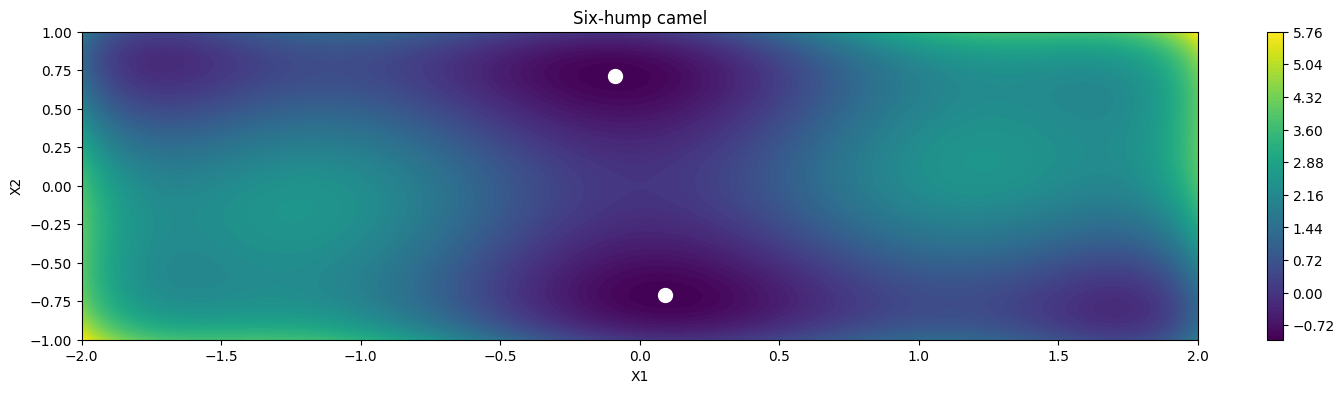

In [94]:
# create the object function
f_true = GPyOpt.objective_examples.experiments2d.sixhumpcamel()
f_true.plot()

### Build the Matern and RBF kernels

## Let's test out the six hump camel 2d example, without noise first in (-3,3),(-2,2)

In [95]:
noise_level = 0.1
def six_hump_camel(x,noise_level=noise_level):
    return (4 - 2.1 * x[0]**2 + (x[0]**4)/3) * x[0]**2 + x[0]*x[1] + (-4 + 4*x[1]**2) * x[1]**2+np.random.randn() * noise_level


In [96]:
def six_hump_camel_wo_noise(x,noise_level=0):
    return (4 - 2.1 * x[0]**2 + (x[0]**4)/3) * x[0]**2 + x[0]*x[1] + (-4 + 4*x[1]**2) * x[1]**2+np.random.randn() * noise_level


### Define RBF Kernel optimizer

In [15]:
def rbf_optimization_six_hump_camel_wo_noise(ncal,l,ac_f):
    
    rbf_kernel = RBF(length_scale=l)
    rbf_gp = GaussianProcessRegressor(kernel=rbf_kernel)

    # Define the search space for Bayesian optimization
    space = [Real(-3, 3, name='x'), Real(-2, 2, name='y')]


    # Perform Bayesian optimization using Gaussian Process regression

    x_list = []    # store the sequence of x point visited
    y_list = []    # store the sequence of y point visited
    function_val = []  # store the sequence of function value attained
    
    #for i in range(n_seed):
    res2d_rbf = gp_minimize(six_hump_camel_wo_noise, 
                  space,      # the bounds on each dimension of x
                  initial_point_generator = "sobol", #initial point generator
                  acq_func=ac_f,      # the acquisition function
                  n_calls=ncal,         # the number of evaluations of f
                  n_random_starts=10,  # the number of random initialization points
                  noise=1e-10,       # the noise level = our selected noise, we set it to 10**-10 if there is no noise.0 causes issues
                  random_state=1234,base_estimator=rbf_gp)   # the random seed

    best_params = res2d_rbf.x
    best_scores = res2d_rbf.fun
    x_iteration = [res2d_rbf.x_iters[i][0] for i in range(len(res2d_rbf.x_iters))]
    y_iteration = [res2d_rbf.x_iters[i][1] for i in range(len(res2d_rbf.x_iters))]
    x_list.append(x_iteration)
    y_list.append(y_iteration)
    
    plt.rcParams["figure.figsize"] = (18, 4)
    plt.subplot(1, 3, 1)
    plt.title("RBF kernel, l = %s, acq_f = %s"%(str(round(l,1)),ac_f))
    plt.ylim(-1,1)
    plt.axhline(y = 0.0898,c='red')
    plt.axhline(y = -0.0898, c='red',label="true x_min")
    plt.ylabel("x_min")
    plt.xlabel("n_calls")
    plt.legend(loc='best')
    plt.plot(x_iteration,marker="o")
    
    plt.subplot(1, 3, 2)
    plt.title("RBF kernel, l = %s, acq_f = %s"%(str(round(l,1)),ac_f))
    plt.ylim(-1,1)
    plt.axhline(y = 0.7126,c='red')
    plt.axhline(y = -0.7126,c='red',label="true y_min")
    plt.ylabel("y_min")
    plt.xlabel("n_calls")
    plt.legend(loc='best')
    plt.plot(y_iteration,marker="o")

    plt.subplot(1, 3, 3)
    plt.title("RBF kernel, l = %s, acq_f = %s"%(str(round(l,1)),ac_f))
    plt.ylim(-1.5,-0.5)
    plt.ylabel("f(x,y)")
    plt.xlabel("n_calls")
    plt.axhline(y = -1.0316, c='red',label = "true function minima")
    plt.plot(res2d_rbf.func_vals,marker="o")
    plt.legend(loc='best')
    plt.show()

    print("best minima location estimate", best_params)
    print("best minima value estimate", best_scores)
    #return best_params,best_score,x_list,y_list,function_val
    

### Define Matern kernel optimizer

In [16]:
def matern_optimization_six_hump_camel_wo_noise(ncal,l,v,ac_f):
    
    matern_kernel = Matern(length_scale=l, nu=v)
    matern_gp = GaussianProcessRegressor(kernel=matern_kernel)

    # Define the search space for Bayesian optimization
    space = [Real(-3, 3, name='x'), Real(-2, 2, name='y')]

    best_params = []
    best_scores = []
    # Perform Bayesian optimization using Gaussian Process regression

    x_list = []    # store the sequence of x point visited
    y_list = []    # store the sequence of y point visited
    function_val = []  # store the sequence of function value attained
    
    #for i in range(n_seed):
    res2d_matern = gp_minimize(six_hump_camel_wo_noise, 
                  space,      # the bounds on each dimension of x
                  initial_point_generator = "sobol", #initial point generator
                  acq_func=ac_f,      # the acquisition function
                  n_calls=ncal,         # the number of evaluations of f
                  n_random_starts=10,  # the number of random initialization points
                  noise=1e-10,       # the noise level = our selected noise, we set it to 10**-10 if there is no noise.0 causes issues
                  random_state=1234,base_estimator=matern_gp)   # the random seed

    best_params.append(res2d_matern.x)
    best_scores.append(res2d_matern.fun)
    x_iteration = [res2d_matern.x_iters[i][0] for i in range(len(res2d_matern.x_iters))]
    y_iteration = [res2d_matern.x_iters[i][1] for i in range(len(res2d_matern.x_iters))]
    x_list.append(x_iteration)
    y_list.append(y_iteration)
    
    plt.rcParams["figure.figsize"] = (18, 4)
    plt.subplot(1, 3, 1)
    plt.title("Matern kernel, l = %s, nu = %s, acq_f = %s"%(str(round(l,1)),str(round(v,1)),ac_f))
    plt.ylim(-1,1)
    plt.axhline(y = 0.0898,c='red')
    plt.axhline(y = -0.0898, c='red',label = "true x_min")    
    plt.ylabel("x_min")
    plt.xlabel("n_calls")
    plt.legend(loc='best')
    plt.plot(x_iteration,marker="o")
    
    plt.subplot(1, 3, 2)
    plt.title("Matern kernel, l = %s, nu = %s, acq_f = %s"%(str(round(l,1)),str(round(v,1)),ac_f))
    plt.ylim(-1,1)
    plt.axhline(y = 0.7126,c='red')
    plt.axhline(y = -0.7126,c='red',label = "true y_min")
    plt.ylabel("y_min")
    plt.xlabel("n_calls")
    plt.legend(loc='best')
    plt.plot(y_iteration,marker="o")

    plt.subplot(1, 3, 3)
    plt.title("Matern kernel, l = %s, nu = %s, acq_f = %s"%(str(round(l,1)),str(round(v,1)),ac_f))
    plt.ylim(-1.5,-0.5)
    plt.ylabel("f(x,y)")
    plt.xlabel("n_calls")
    plt.axhline(y = -1.0316, c='red',label = "true function minima")
    plt.plot(res2d_matern.func_vals,marker="o")
    plt.legend(loc='best')
    plt.show()

    print("best minima location estimate", best_params)
    print("best minima value estimate", best_scores)
    #return best_params,best_score,x_list,y_list,function_val
    

<br> $\color{red}{\text{Discussion}}$ Optimizing the six hump camel function without noise. Using ncalls = 50, n_restart = 10, "LCB" acquisition function with exploration/exploitation ratio = 1.96(default value from scikit gp_minimize). We use the same initial seed value for comparison, with a "sobol" sampling for even tiling of 2d space. Refer to the plots below for convergence. (l = correlation length of kernel, v=smoothness parameter of Matern kernel). (red lines in x_min, y_min plots are true minima location). Configurations that get close to actual function minima are highlighted in red.

RBF Kernel

| Noise level | Kernel |   Acquisition function   | l  | $x_{min}$|  $y_{min}$ | f($x_{min}$) |  
|:--------:| :---:|:------: | :----:| :----:| :-----: | :-----: | 
| 0.0        |  RBF   | LCB  | 1.0 |  0.04308384400701115| -0.5477895914281512 | -0.856300721149796 |  
| 0.0        |  RBF   | LCB  | 0.5 | 0.04308384400701115| -0.5477895914281512 |-0.856300721149796|
| 0.0        |  RBF   | LCB  | $\color{red}{0.1}$ | 0.08984093595846909 | -0.7126458530416093 |-1.0316284525852675 |

Matern kernel

| Noise level | Kernel |   Acquisition function   | l  | v   | $x_{min}$|  $y_{min}$ | f($x_{min}$) |  
|:--------:| :---:|:------: | :----:| :----:| :-----:| :-----: | :-----: | 
| 0.0        |  Matern32   | LCB  | 1.0 | 1.5   | 0.04308384400701115 | -0.5477895914281512 |-0.856300721149796 |  
| 0.0        |  Matern32   | LCB  | 1.0 | 2.5   | 0.04308384400701115 | -0.5477895914281512 |-0.856300721149796 |
| 0.0        |  Matern32   | LCB  | 0.5 | 1.5   | 0.04308384400701115| -0.5477895914281512 |-0.856300721149796 |             
| 0.0        |  Matern32   | LCB  | 0.5 | 2.5   | 0.04308384400701115 | -0.5477895914281512 |-0.856300721149796 |
| 0.0        |  Matern32   | LCB  | $\color{red}{0.1}$ | 1.5   | 0.0903876288815253 | -0.7128990597794449 |-1.0316269430462777 |
| 0.0        |  Matern32   | LCB  | $\color{red}{0.1}$ | 2.5   | 0.08985140925517143 | -0.7126551031853843 |-1.0316284531196278 |

Note that for both the RBF and the Matern kernel, the optimizer fails to recover the minima location whenver the correlation length $l \geq 0.5$. This is because of the fact that the gp learns about the underlying function on the lengthscale set by the value $l$, so if extremas in the underlying functions are seperated by distance shorter than l, then optimization fails to tfind them.

For both the Matern and the RBF Kernel, the correct minimas locations and function minima value were found by the optimizer at l=0.1. The Matern 3/2 kernel leads to quicker optimization, we reach the function minima for less than 20 iterations and hit an exploitation loop. The Matern 5/2 and RBF Kernel also reach the minima around 20 iterations, but they wander off after a few iterations before eventually entering an exploitation loop

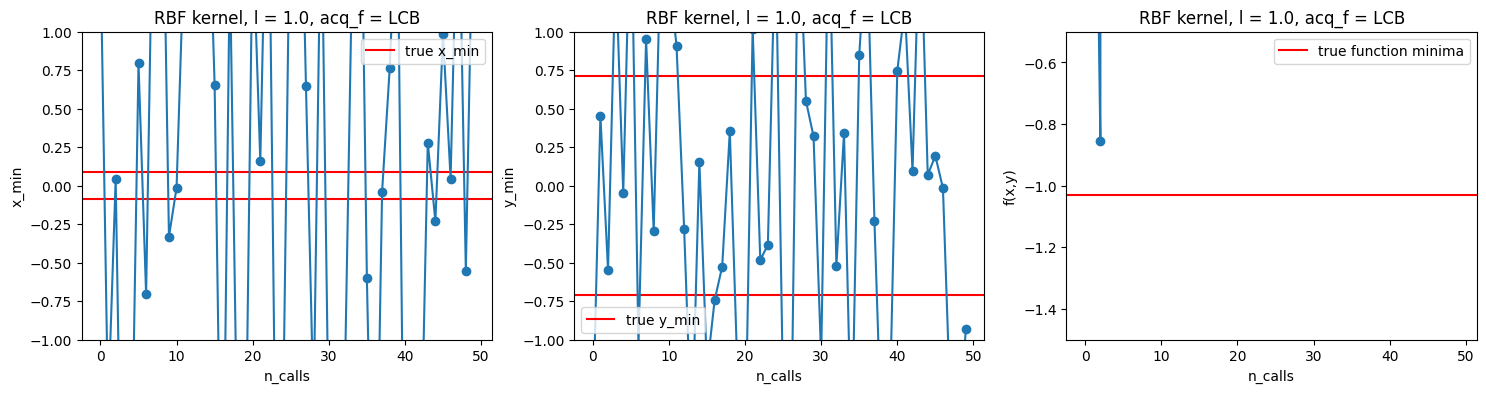

best minima location estimate [0.04308384400701115, -0.5477895914281512]
best minima value estimate -0.856300721149796


In [29]:
ncal=50; l=1.0; ac_f = "LCB"
rbf_optimization_six_hump_camel_wo_noise(ncal,l,ac_f)

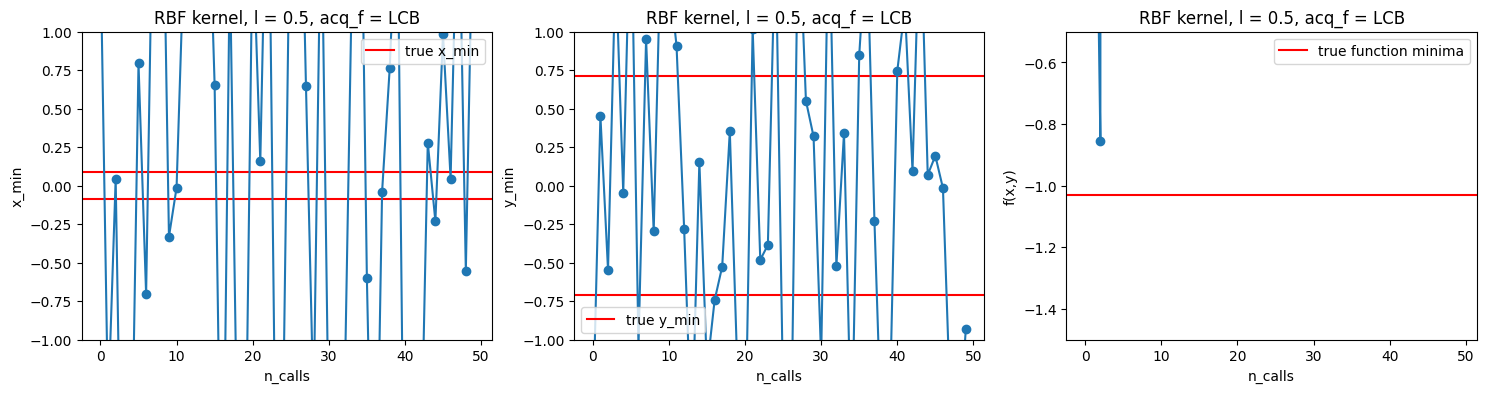

best minima location estimate [0.04308384400701115, -0.5477895914281512]
best minima value estimate -0.856300721149796


In [30]:
ncal=50; l=0.5; ac_f = "LCB"
rbf_optimization_six_hump_camel_wo_noise(ncal,l,ac_f)

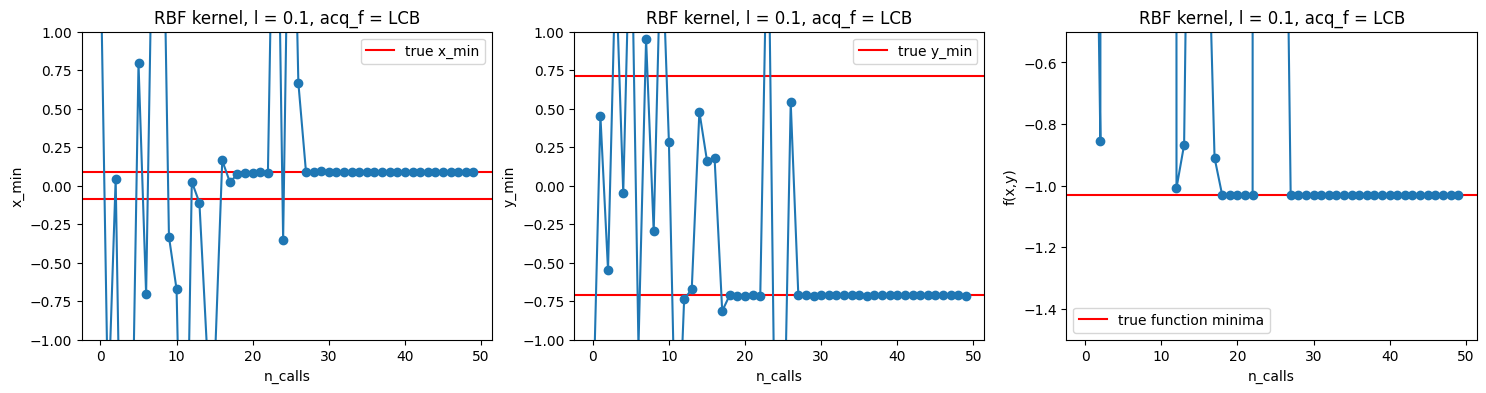

best minima location estimate [0.08984093595846909, -0.7126458530416093]
best minima value estimate -1.0316284525852675


In [31]:
ncal=50; l=0.1; ac_f = "LCB"
rbf_optimization_six_hump_camel_wo_noise(ncal,l,ac_f)

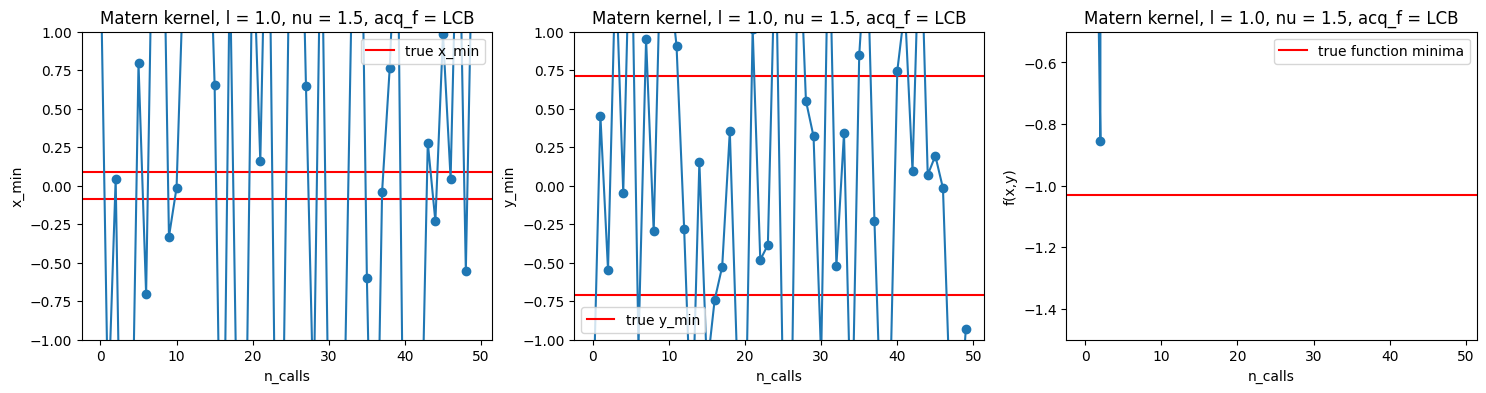

best minima location estimate [[0.04308384400701115, -0.5477895914281512]]
best minima value estimate [-0.856300721149796]


In [32]:
ncal=50; l=1.0; v = 1.5; ac_f = "LCB"
matern_optimization_six_hump_camel_wo_noise(ncal,l,v,ac_f)

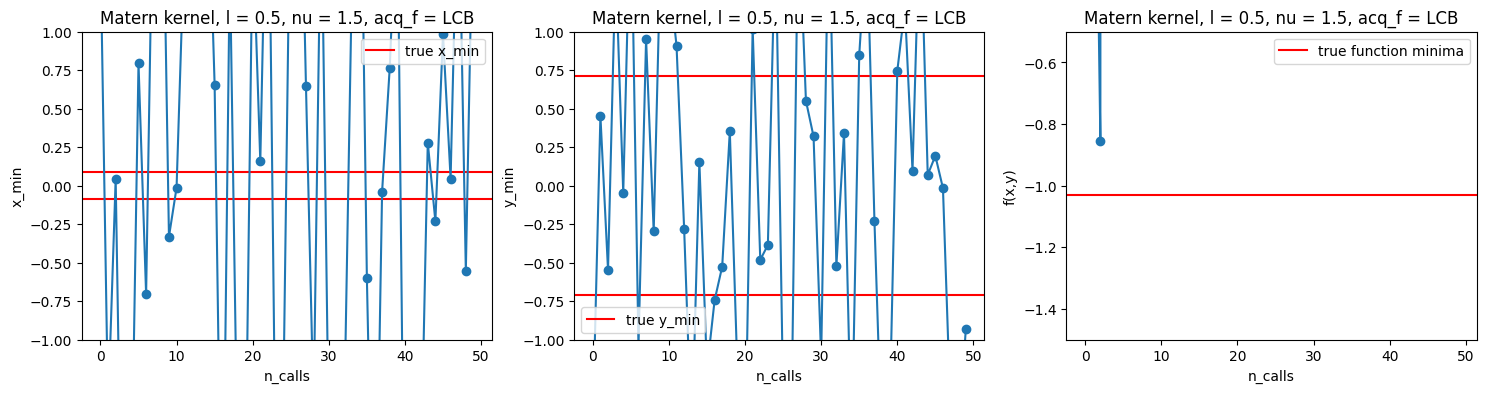

best minima location estimate [[0.04308384400701115, -0.5477895914281512]]
best minima value estimate [-0.856300721149796]


In [33]:
ncal=50; l=0.5; v = 1.5; ac_f = "LCB"
matern_optimization_six_hump_camel_wo_noise(ncal,l,v,ac_f)

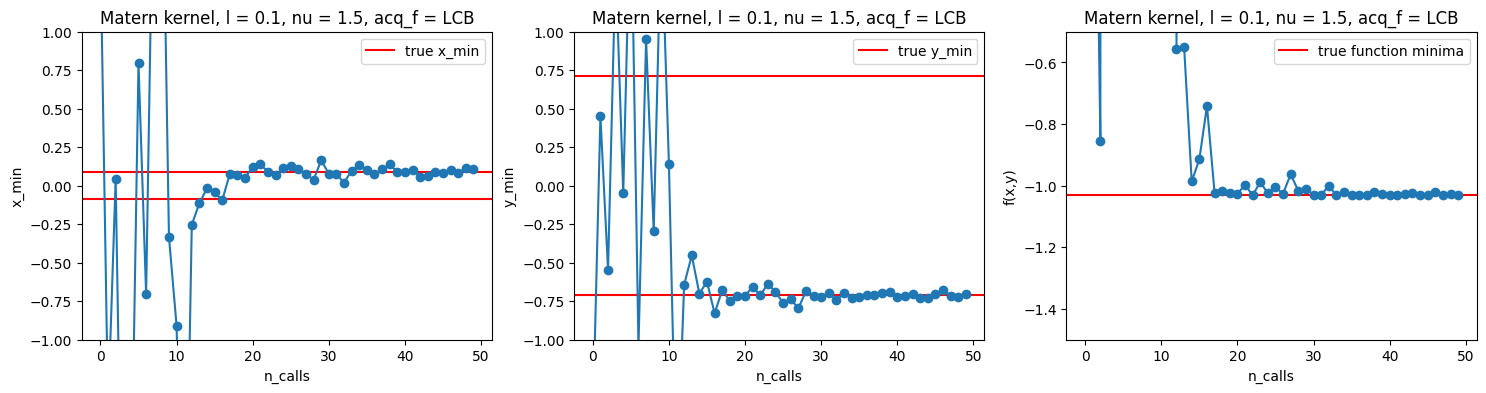

best minima location estimate [[0.0903876288815253, -0.7128990597794449]]
best minima value estimate [-1.0316269430462777]


In [34]:
ncal=50; l=0.1; v = 1.5; ac_f = "LCB"
matern_optimization_six_hump_camel_wo_noise(ncal,l,v,ac_f)

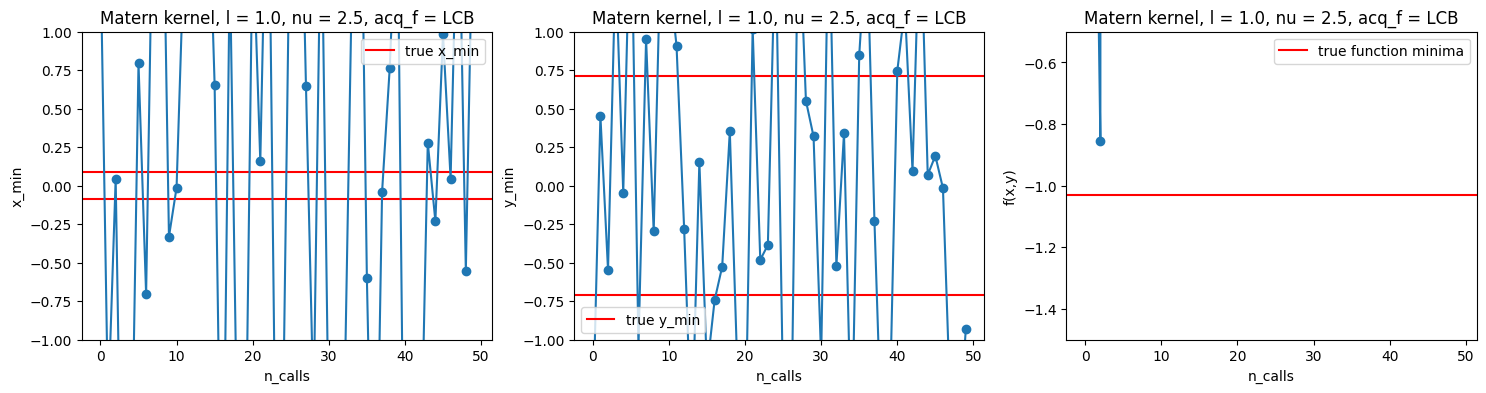

best minima location estimate [[0.04308384400701115, -0.5477895914281512]]
best minima value estimate [-0.856300721149796]


In [35]:
ncal=50; l=1.0; v = 2.5; ac_f = "LCB"
matern_optimization_six_hump_camel_wo_noise(ncal,l,v,ac_f)

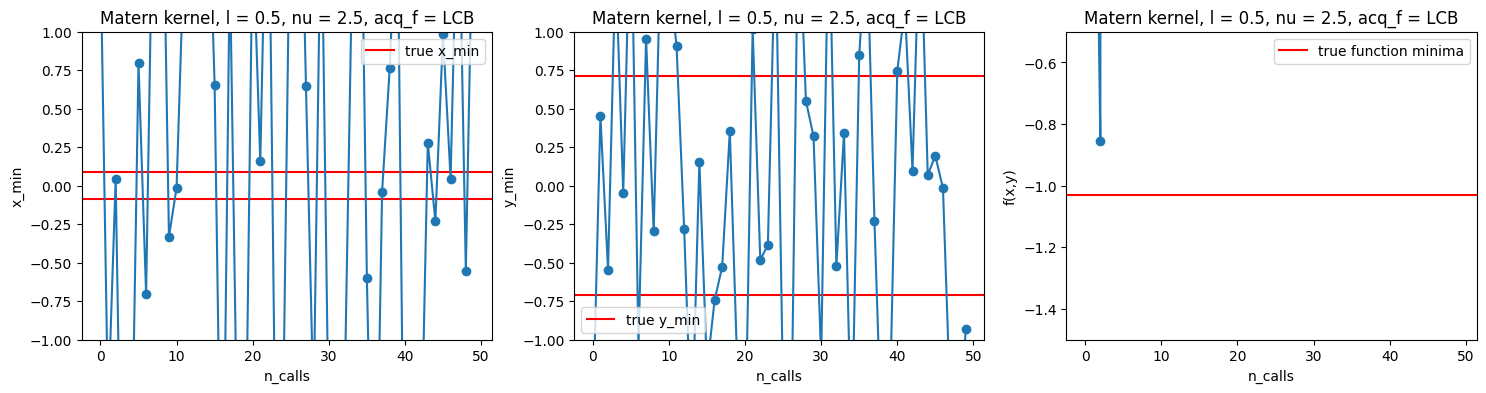

best minima location estimate [[0.04308384400701115, -0.5477895914281512]]
best minima value estimate [-0.856300721149796]


In [36]:
ncal=50; l=0.5; v = 2.5; ac_f = "LCB"
matern_optimization_six_hump_camel_wo_noise(ncal,l,v,ac_f)

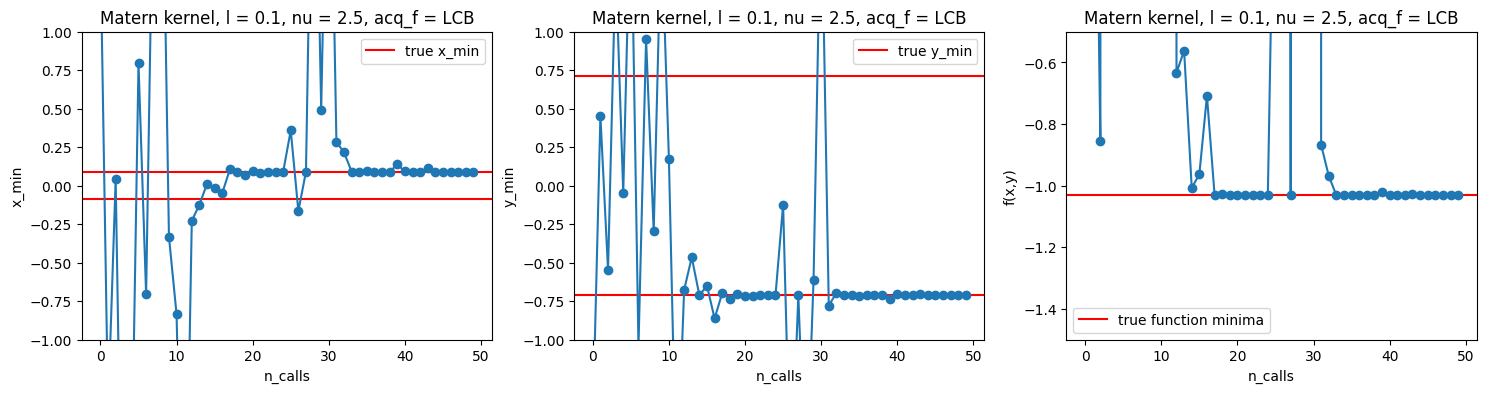

best minima location estimate [[0.08985140925517143, -0.7126551031853843]]
best minima value estimate [-1.0316284531196278]


In [37]:
ncal=50; l=0.1; v = 2.5; ac_f = "LCB"
matern_optimization_six_hump_camel_wo_noise(ncal,l,v,ac_f)

## Six hump camel with noise in (-3,3) ,(-2,2)

### Define RBF Kernel optimizer

In [50]:
def rbf_optimization_six_hump_camel(noise_val,ncal,l,ac_f):
    
    rbf_kernel = RBF(length_scale=l)
    rbf_gp = GaussianProcessRegressor(kernel=rbf_kernel)

    # Define the search space for Bayesian optimization
    space = [Real(-3, 3, name='x'), Real(-2, 2, name='y')]


    # Perform Bayesian optimization using Gaussian Process regression

    x_list = []    # store the sequence of x point visited
    y_list = []    # store the sequence of y point visited
    function_val = []  # store the sequence of function value attained
    
    #for i in range(n_seed):
    res2d_rbf = gp_minimize(six_hump_camel, 
                  space,      # the bounds on each dimension of x
                  initial_point_generator = "sobol", #initial point generator
                  acq_func=ac_f,      # the acquisition function
                  n_calls=ncal,         # the number of evaluations of f
                  n_random_starts=10,  # the number of random initialization points
                  noise=noise_val**2,       # the noise level = our selected noise, we set it to 10**-10 if there is no noise.0 causes issues
                  random_state=1234,base_estimator=rbf_gp)   # the random seed

    best_params = res2d_rbf.x
    best_scores = res2d_rbf.fun
    x_iteration = [res2d_rbf.x_iters[i][0] for i in range(len(res2d_rbf.x_iters))]
    y_iteration = [res2d_rbf.x_iters[i][1] for i in range(len(res2d_rbf.x_iters))]
    x_list.append(x_iteration)
    y_list.append(y_iteration)
    
    plt.rcParams["figure.figsize"] = (18, 4)
    plt.subplot(1, 3, 1)
    plt.title("RBF kernel, noise = %s, l = %s, acq_f = %s"%(str(noise_val),str(round(l,1)),ac_f))
    plt.ylim(-1,1)
    plt.axhline(y = 0.0898,c='red')
    plt.axhline(y = -0.0898, c='red',label="true x_min")
    plt.ylabel("x_min")
    plt.xlabel("n_calls")
    plt.legend(loc='best')
    plt.plot(x_iteration,marker="o")
    
    plt.subplot(1, 3, 2)
    plt.title("RBF kernel, noise = %s, l = %s, acq_f = %s"%(str(noise_val),str(round(l,1)),ac_f))
    plt.ylim(-1,1)
    plt.axhline(y = 0.7126,c='red')
    plt.axhline(y = -0.7126,c='red',label="true y_min")
    plt.ylabel("y_min")
    plt.xlabel("n_calls")
    plt.legend(loc='best')
    plt.plot(y_iteration,marker="o")

    plt.subplot(1, 3, 3)
    plt.title("RBF kernel, noise = %s, l = %s, acq_f = %s"%(str(noise_val),str(round(l,1)),ac_f))
    plt.ylim(-1.5,-0.5)
    plt.ylabel("f(x,y)")
    plt.xlabel("n_calls")
    plt.axhline(y = -1.0316, c='red',label = "true function minima")
    plt.plot(res2d_rbf.func_vals,marker="o")
    plt.legend(loc='best')
    plt.show()

    print("best minima location estimate", best_params)
    print("best minima value estimate", best_scores)

### Define Matern Kernel optimizer

In [182]:
def matern_optimization_six_hump_camel(noise_val,ncal,l,v,ac_f):
    
    matern_kernel = Matern(length_scale=l, nu=v)
    matern_gp = GaussianProcessRegressor(kernel=matern_kernel)

    # Define the search space for Bayesian optimization
    space = [Real(-3, 3, name='x'), Real(-2, 2, name='y')]

    best_params = []
    best_scores = []
    # Perform Bayesian optimization using Gaussian Process regression

    x_list = []    # store the sequence of x point visited
    y_list = []    # store the sequence of y point visited
    function_val = []  # store the sequence of function value attained
    
    #for i in range(n_seed):
    res2d_matern = gp_minimize(six_hump_camel, 
                  space,      # the bounds on each dimension of x
                  initial_point_generator = "sobol", #initial point generator
                  acq_func=ac_f,      # the acquisition function
                  n_calls=ncal,         # the number of evaluations of f
                  n_random_starts=10,  # the number of random initialization points
                  noise=1e-10,       # the noise level = our selected noise, we set it to 10**-10 if there is no noise.0 causes issues
                  random_state=1234,base_estimator=matern_gp)   # the random seed

    best_params.append(res2d_matern.x)
    best_scores.append(res2d_matern.fun)
    x_iteration = [res2d_matern.x_iters[i][0] for i in range(len(res2d_matern.x_iters))]
    y_iteration = [res2d_matern.x_iters[i][1] for i in range(len(res2d_matern.x_iters))]
    x_list.append(x_iteration)
    y_list.append(y_iteration)
    
    plt.rcParams["figure.figsize"] = (18, 4)
    plt.subplot(1, 3, 1)
    plt.title("Matern kernel, noise = %s, l = %s, nu = %s, acq_f = %s"%(str(noise_val),str(l),str(v),ac_f))
    plt.ylim(-1,1)
    plt.axhline(y = 0.0898,c='red')
    plt.axhline(y = -0.0898, c='red',label = "true x_min")    
    plt.ylabel("x_min")
    plt.xlabel("n_calls")
    plt.legend(loc='best')
    plt.plot(x_iteration,marker="o")
    
    plt.subplot(1, 3, 2)
    plt.title("Matern kernel, noise = %s, l = %s, nu = %s, acq_f = %s"%(str(noise_val),str(l),str(v),ac_f))
    plt.ylim(-1,1)
    plt.axhline(y = 0.7126,c='red')
    plt.axhline(y = -0.7126,c='red',label = "true y_min")
    plt.ylabel("y_min")
    plt.xlabel("n_calls")
    plt.legend(loc='best')
    plt.plot(y_iteration,marker="o")

    plt.subplot(1, 3, 3)
    plt.title("Matern kernel, noise = %s, l = %s, nu = %s, acq_f = %s"%(str(noise_val),str(l),str(v),ac_f))
    plt.ylim(-1.5,-0.5)
    plt.ylabel("f(x,y)")
    plt.xlabel("n_calls")
    plt.axhline(y = -1.0316, c='red',label = "true function minima")
    plt.plot(res2d_matern.func_vals,marker="o")
    plt.legend(loc='best')
    plt.show()

    print("best minima location estimate", best_params)
    print("best minima value estimate", best_scores)
    #return best_params,best_score,x_list,y_list,function_val
    

 # Start with a small noise, n=0.001

<br> $\color{red}{\text{Discussion}}$ Optimizing the six hump camel function with noise. Using ncalls = 50, n_restart = 10, "LCB" acquisition function with exploration/exploitation ratio = 1.96(default value from scikit gp_minimize). We use the same initial seed value for comparison, with a "sobol" sampling for even tiling of 2d space. Refer to the plots below for convergence. Configurations that get close the function minima are highlighted in red.

RBF Kernel

| Noise level | Kernel |   Acquisition function   | l  | $x_{min}$|  $y_{min}$ | f($x_{min}$) |  
|:--------:| :---:|:------: | :----:| :----:| :-----: | :-----: | 
| 0.001        |  RBF   | LCB  | 1.0 | 0.04308384400701115 | -0.5477895914281512 | -0.8552037777466018 |  
| 0.001        |  RBF   | LCB  | 0.5 | 0.04308384400701115 | -0.5477895914281512 | -0.8573183659296113|
| 0.001        |  RBF   | LCB  | 0.2 | 0.04308384400701115 | -0.5477895914281512 | -0.855837539819732 |
| 0.001        |  RBF   | LCB  | $\color{red}{0.1}$ | 0.07437084032236196 | -0.70933664553765   | -1.031403444004104 |


Matern kernel

| Noise level | Kernel |   Acquisition function   | l  | v   | $x_{min}$|  $y_{min}$ | f($x_{min}$) |  
|:--------:| :---:|:------: | :----:| :----:| :-----:| :-----: | :-----: | 
| 0.001        |  Matern32   | LCB  | 1.0 | 1.5   | 0.04308384400701115 | -0.5477895914281512 |-0.8581040823760402 |
| 0.001        |  Matern32   | LCB  | 1.0 | 2.5   | 0.04308384400701115 | -0.5477895914281512 |-0.8550503545164263 |
| 0.001        |  Matern32   | LCB  | 0.5 | 1.5   | 0.04308384400701115 | -0.5477895914281512 |-0.8563626314109383 |   
| 0.001        |  Matern32   | LCB  | 0.5 | 2.5   | 0.04308384400701115 | -0.5477895914281512 |-0.8566638811537142 |
| 0.001        |  Matern32   | LCB  | $\color{red}{0.2}$ | 1.5   | 0.1023842992524342  | -0.7054220976700549 |-1.0332919103593294 |
| 0.001        |  Matern32   | LCB  | $\color{red}{0.2}$ | 2.5   | 0.08405454463339401 | -0.7149136735556254 |-1.033022626250192  |
| 0.001        |  Matern32   | LCB  | $\color{red}{0.1}$ | 1.5   | 0.0807892673616677  | -0.7108448453011955 |-1.0316133015729554 |
| 0.001        |  Matern32   | LCB  | $\color{red}{0.1}$ | 2.5   | 0.09707073689434065 | -0.7144778555218352 |-1.032373724521662  |


Note that for both the RBF and the Matern kernel, the optimizer fails to recover the minima location whenver the correlation length $l \geq 0.5$. The biggest difference for the RBF Kernel, comes at correlation length l = 0.1. For the noiseless case, the RBF kernel could identify the minima location and value, while remaining in an exploitative loop towards the end of the iterations. For the noisy case, the RBF kernel could identify the minima location and value somewhat closely, however, it could never enter the exploitative phase.

The Matern Kernel comes out to be the better one in regard to noisy objective function. We reach approximate function minima with a larger correlation length $l=0.2$. As in the noiseless case, the Matern kernel with $v=1.5$ yeilds a larger exploitation region compared to Matern $2.5$ kernel. We can possibly tie it to the fact that Matern 1.5 is singly differentiable, and more tailored towards smoother function(like the six hump camel), while Matern 2.5 is twice differentiable and more tailored towards optimizing rougher functions. Hence, with the six hump camel, Matern 2.5 tries to find more structure(as in case of rougher objective functions) and hence spends more time in the exploration regime.(This is analogous a model overfitting in regression problems)

## RBF kernel results, noise = 0.001

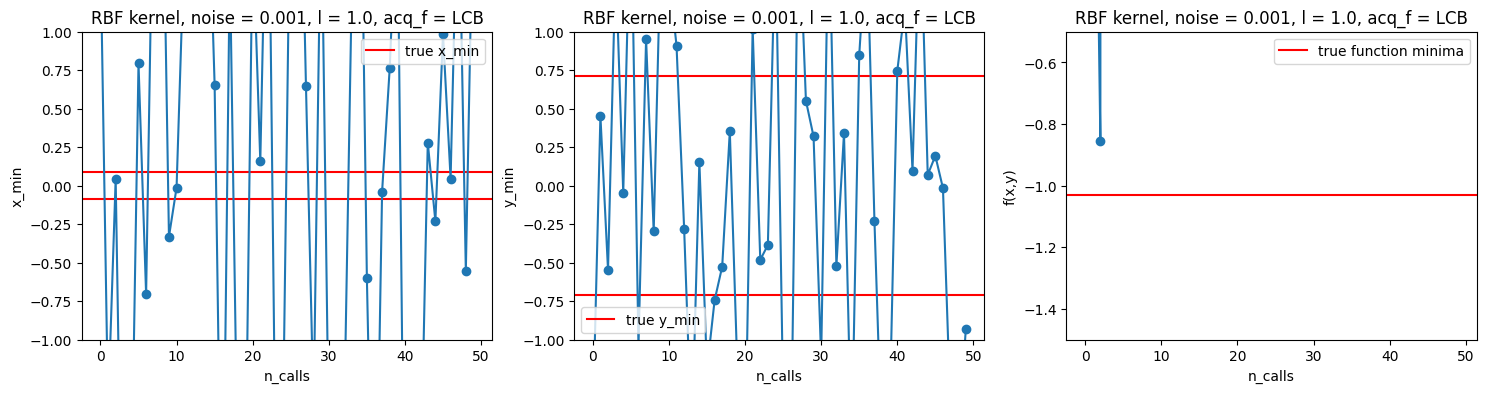

best minima location estimate [0.04308384400701115, -0.5477895914281512]
best minima value estimate -0.8552037777466018


In [52]:
ncal=50; l = 1.0; ac_f = "LCB"
rbf_optimization_six_hump_camel(noise_level,ncal,l,ac_f)

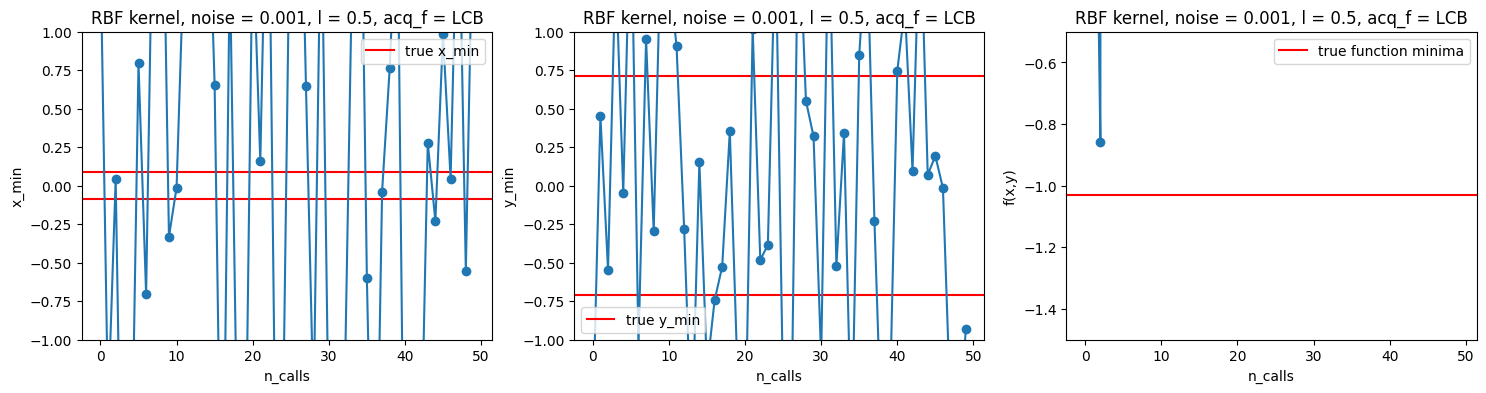

best minima location estimate [0.04308384400701115, -0.5477895914281512]
best minima value estimate -0.8573183659296113


In [53]:
ncal=50; l = 0.5; ac_f = "LCB"
rbf_optimization_six_hump_camel(noise_level,ncal,l,ac_f)

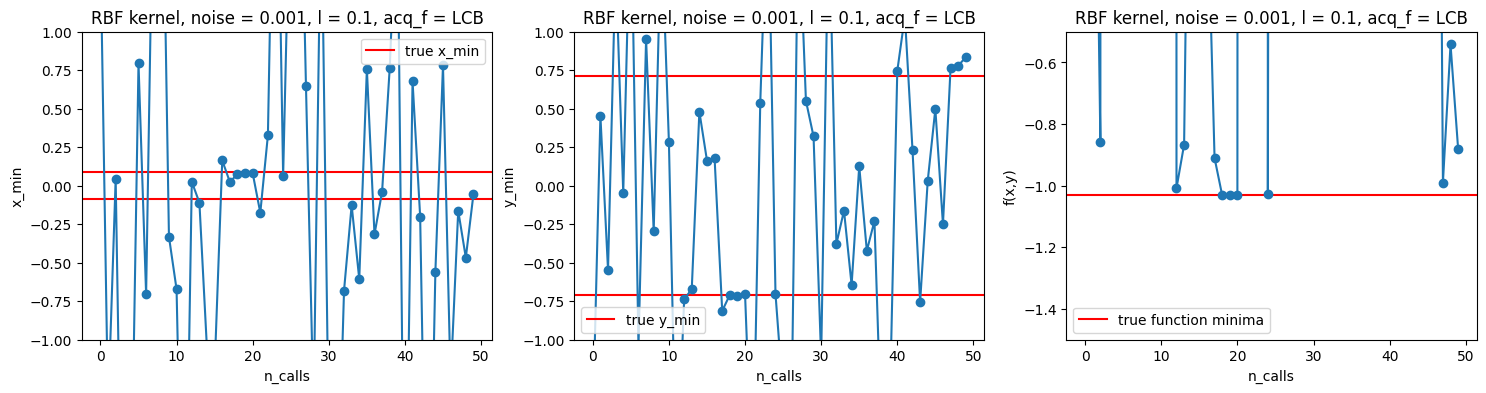

best minima location estimate [0.07437084032236196, -0.70933664553765]
best minima value estimate -1.0314034440041047


In [54]:
ncal=50; l = 0.1; ac_f = "LCB"
rbf_optimization_six_hump_camel(noise_level,ncal,l,ac_f)

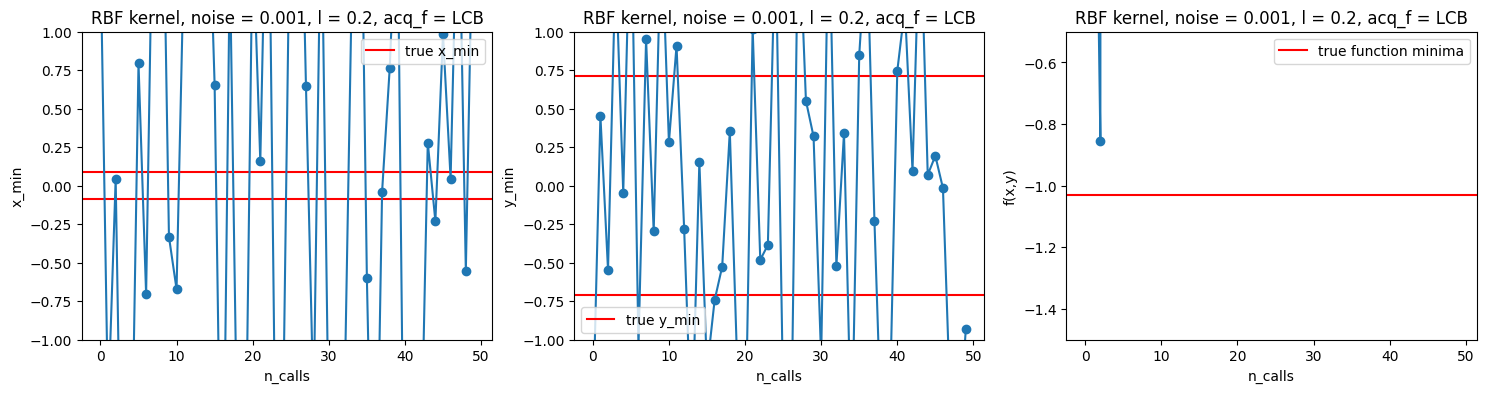

best minima location estimate [0.04308384400701115, -0.5477895914281512]
best minima value estimate -0.855837539819732


In [55]:
ncal=50; l = 0.2; ac_f = "LCB"
rbf_optimization_six_hump_camel(noise_level,ncal,l,ac_f)

## Matern Kernel results, noise = 0.001

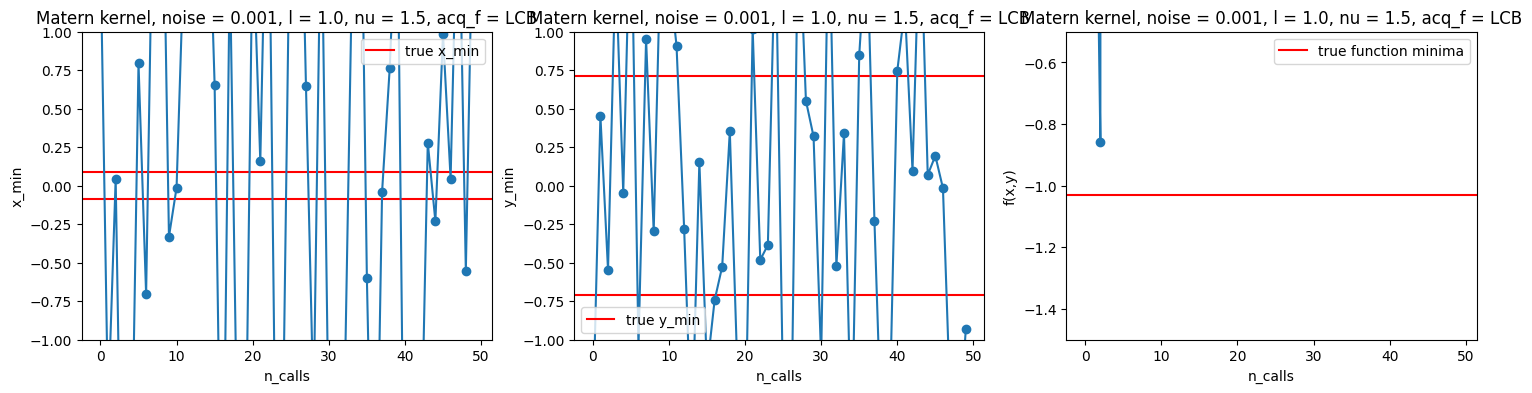

best minima location estimate [[0.04308384400701115, -0.5477895914281512]]
best minima value estimate [-0.8581040823760402]


In [56]:
ncal=50; l = 1.0; v = 1.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

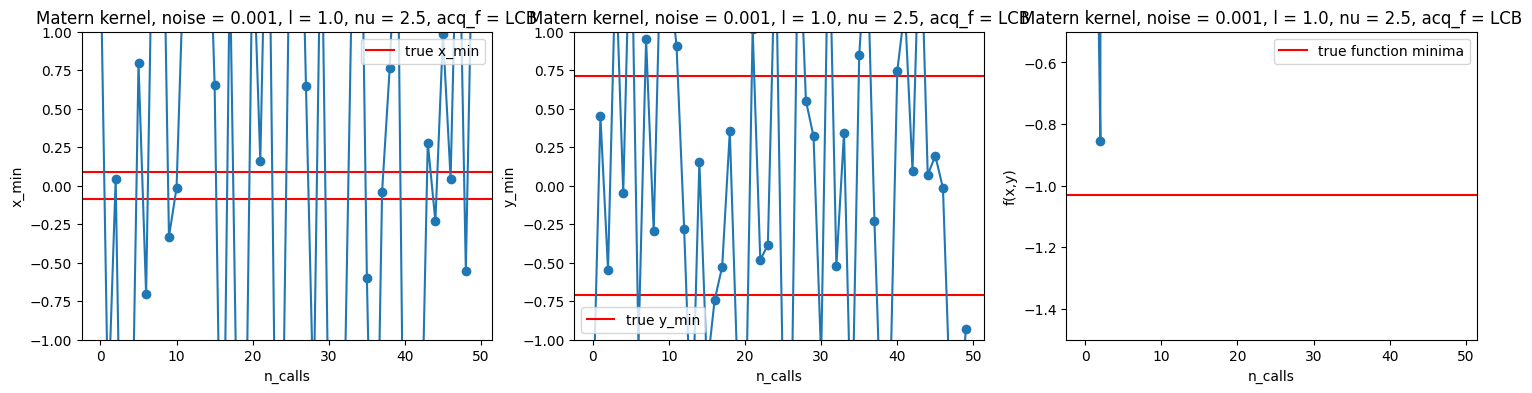

best minima location estimate [[0.04308384400701115, -0.5477895914281512]]
best minima value estimate [-0.8550503545164263]


In [57]:
ncal=50; l = 1.0; v = 2.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

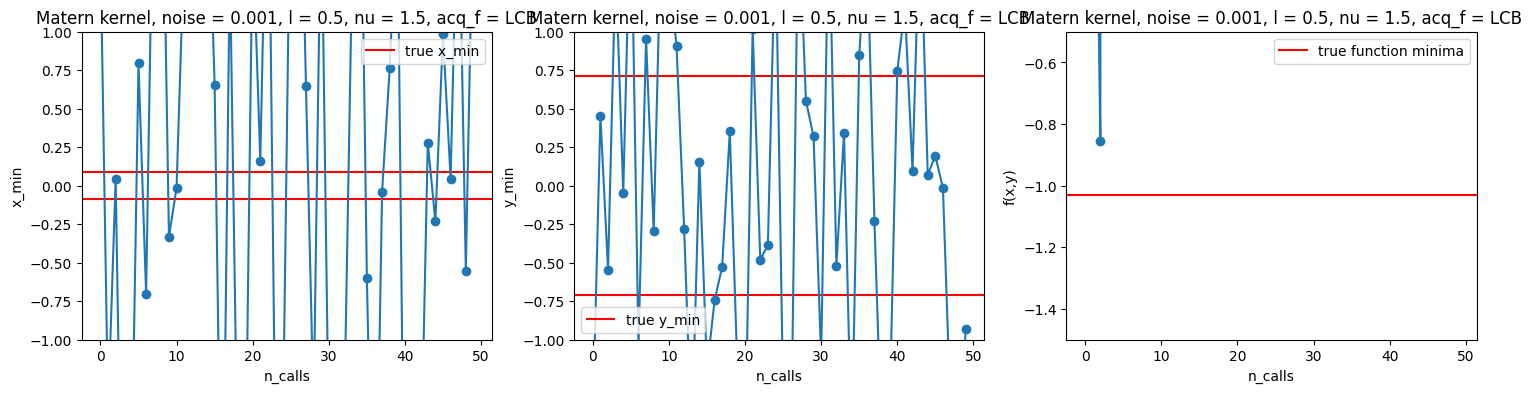

best minima location estimate [[0.04308384400701115, -0.5477895914281512]]
best minima value estimate [-0.8563626314109383]


In [58]:
ncal=50; l = 0.5; v = 1.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

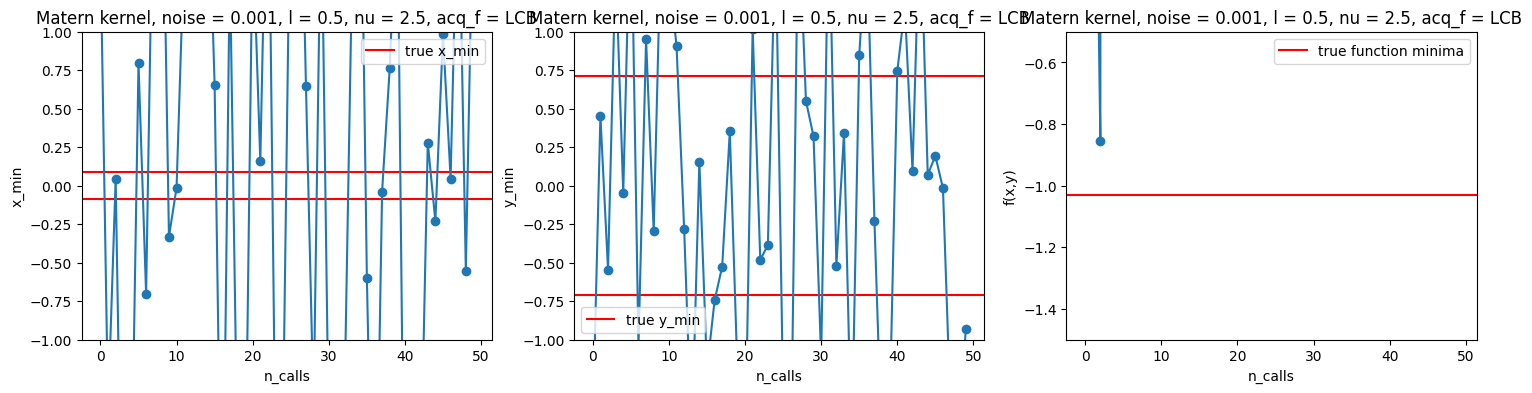

best minima location estimate [[0.04308384400701115, -0.5477895914281512]]
best minima value estimate [-0.8566638811537142]


In [59]:
ncal=50; l = 0.5; v = 2.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

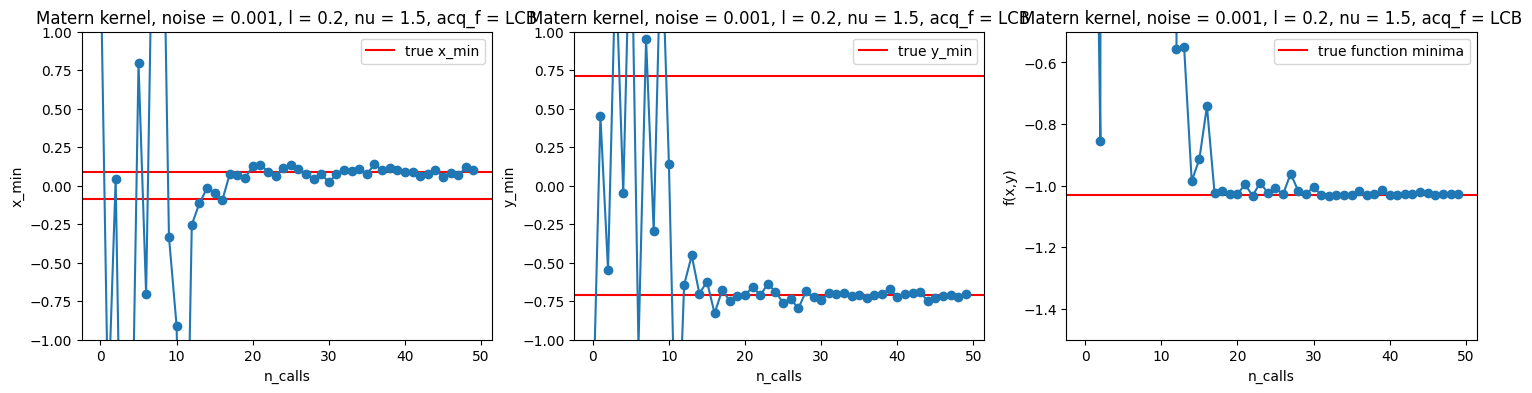

best minima location estimate [[0.1023842992524342, -0.7054220976700549]]
best minima value estimate [-1.0332919103593294]


In [60]:
ncal=50; l = 0.2; v = 1.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

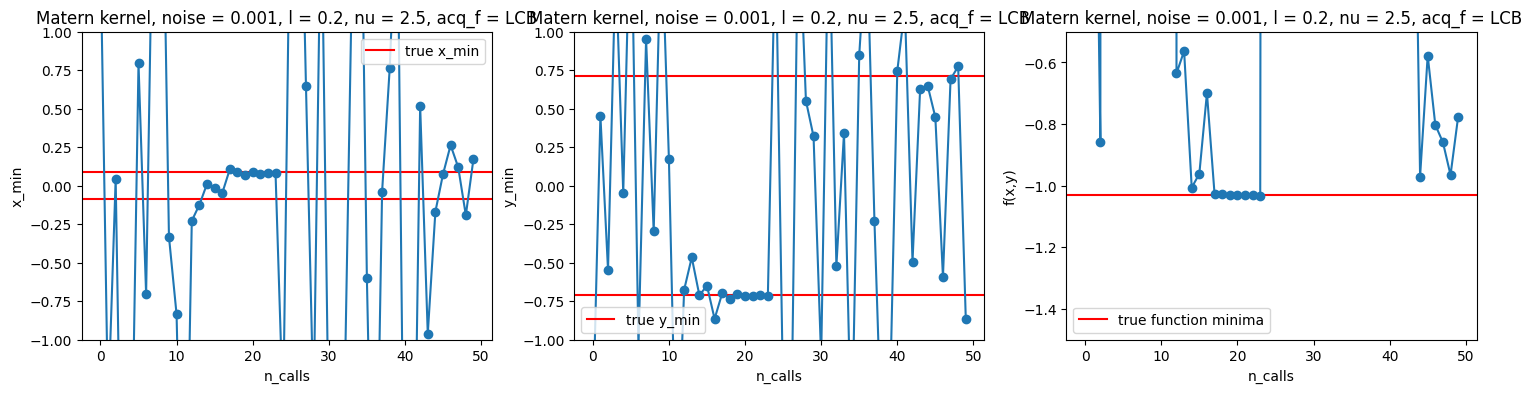

best minima location estimate [[0.08405454463339401, -0.7149136735556254]]
best minima value estimate [-1.033022626250192]


In [62]:
ncal=50; l = 0.2; v = 2.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

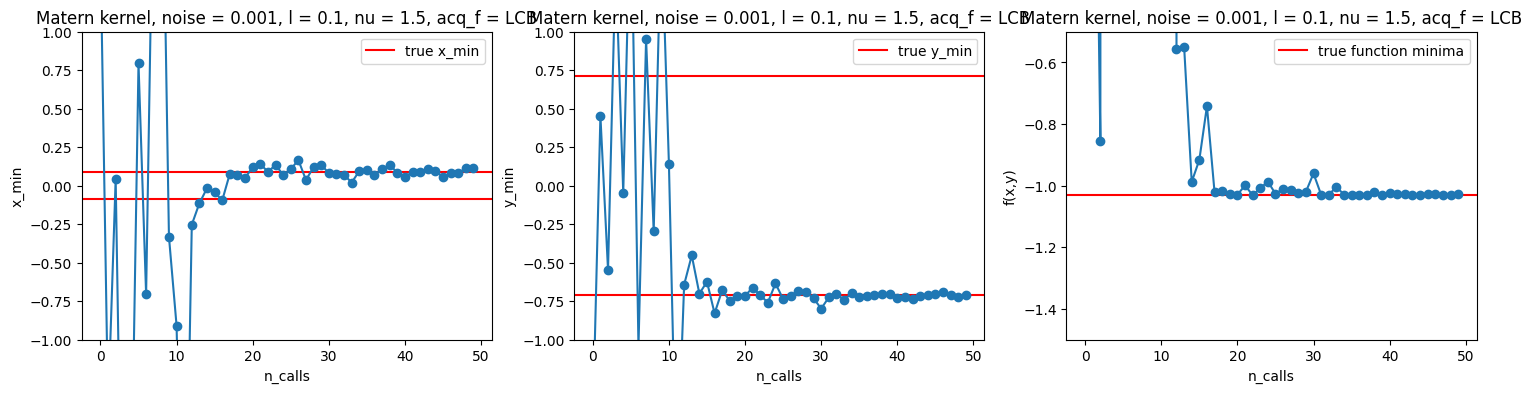

best minima location estimate [[0.0807892673616677, -0.7108448453011955]]
best minima value estimate [-1.0316133015729554]


In [63]:
ncal=50; l = 0.1; v = 1.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

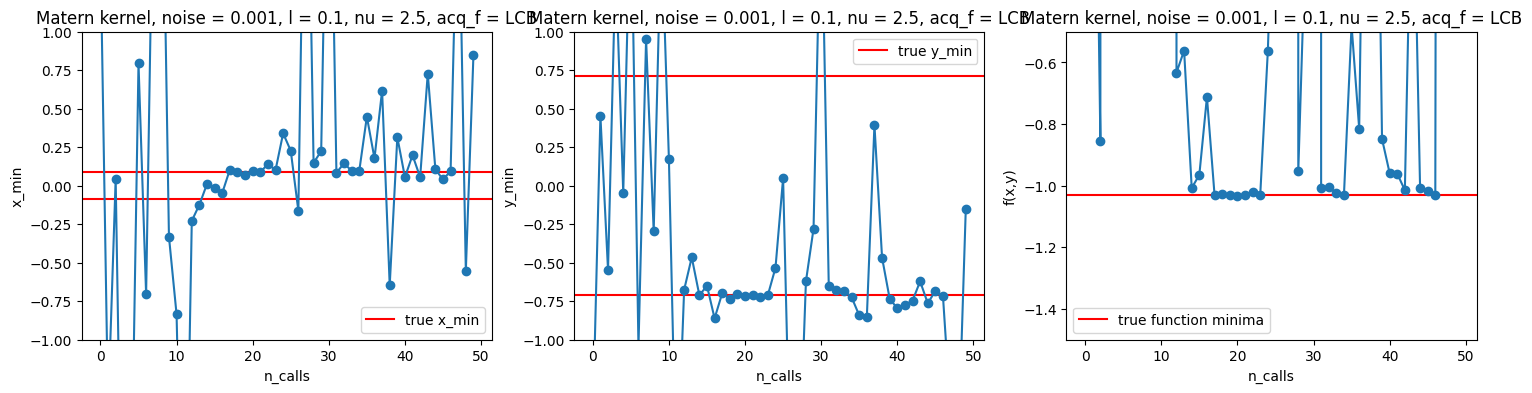

best minima location estimate [[0.09707073689434065, -0.7144778555218352]]
best minima value estimate [-1.032373724521662]


In [64]:
ncal=50; l = 0.1; v = 2.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

# Increase the noise to n = 0.01

<br> $\color{red}{\text{Discussion}}$ Optimizing the six hump camel function with larger noise. Using ncalls = 50, n_restart = 10, "LCB" acquisition function with exploration/exploitation ratio = 1.96(default value from scikit gp_minimize). We use the same initial seed value for comparison, with a "sobol" sampling for even tiling of 2d space. Refer to the plots below for convergence. Configurations that get close the function minima are highlighted in red.

RBF Kernel

| Noise level | Kernel |   Acquisition function   | l  | $x_{min}$|  $y_{min}$ | f($x_{min}$) |  
|:--------:| :---:|:------: | :----:| :----:| :-----: | :-----: | 
| 0.01        |  RBF   | LCB  | 1.0 | 0.04308384400701115 | -0.5477895914281512 | -0.8476826880492819 |  
| 0.01        |  RBF   | LCB  | 0.5 | 0.04308384400701115 | -0.5477895914281512 | -0.8700063978203436 |
| 0.01        |  RBF   | LCB  | 0.2 | 0.04308384400701115 | -0.5477895914281512 | -0.8605768295775252 |
| 0.01        |  RBF   | LCB  | $\color{red}{0.1}$ | 0.08981907315934734 | -0.7128883606284226 | -1.0531639910222728 |

Matern kernel

| Noise level | Kernel |   Acquisition function   | l  | v   | $x_{min}$|  $y_{min}$ | f($x_{min}$) |  
|:--------:| :---:|:------: | :----:| :----:| :-----:| :-----: | :-----: | 
| 0.01        |  Matern32   | LCB  | 1.0 | 1.5   | 0.04308384400701115 | -0.5477895914281512 |-0.8505464187128731 |
| 0.01        |  Matern32   | LCB  | 1.0 | 2.5   | 0.04308384400701115 | -0.5477895914281512 |-0.8406679842554393 |
| 0.01        |  Matern32   | LCB  | 0.5 | 1.5   | 0.04308384400701115 | -0.5477895914281512 |-0.8653365929841212 |   
| 0.01        |  Matern32   | LCB  | 0.5 | 2.5   | 0.04308384400701115 | -0.5477895914281512 |-0.8597101211826687 |
| 0.01        |  Matern32   | LCB  | $\color{red}{0.2}$ | 1.5   | 0.08737527825385971 | -0.7153691888886116 |-1.0522943379145686 |
| 0.01        |  Matern32   | LCB  | 0.2 | 2.5   | 0.06624729413064179 | -0.7315100750481043 |-1.0408606528127102 |
| 0.01        |  Matern32   | LCB  | $\color{red}{0.1}$ | 1.5   | 0.09547412883770612 | -0.6940230831109018 |-1.0434295762495687 |
| 0.01        |  Matern32   | LCB  | $\color{red}{0.1}$ | 2.5   | 0.07846084926304231 | -0.6866293357348343 |-1.0359808148281973 |

With increased noise $n=0.01$, the RBF Kernel has similar performance compared to the less noisy case ($n=0.001$). Function minima couldn't be found with $l \geq 0.2$. Similar to the $n=0.001$ case, the RBF kernel cannot enter the exploitative regime at all.

The Matern Kernel again comes out to be the better one in regard to noisy objective function. We reach approximate function minima with a larger correlation length $l=0.2$. However, note that compared to n = 0.001 case, the Matern Kernel performance worsens in regard to convergence. Although at $l=0.2, v =1.5$, we get close to the function value, the optimizer wanders off sporadically in the exploitative loop, compared to the lower(n=0.001) case. Convergence increases with lowering correlation to $l=0.1$, however, it still weaker than the corresponding configuration for $n=0.001$

For the Matern $v=2.5$ kernel, the performace is worse for $l = 0.2$ vs $l=0.1$ case. While the kernel predicted the approximate minima at $l =0.2$ for $n = 0.001$, it failed to do so for $n=0.01$. Lowering correlation length to $l=0.1$ increases performance, but convergence is weaker due to larger noise. 

## RBF kernel results, noise = 0.01

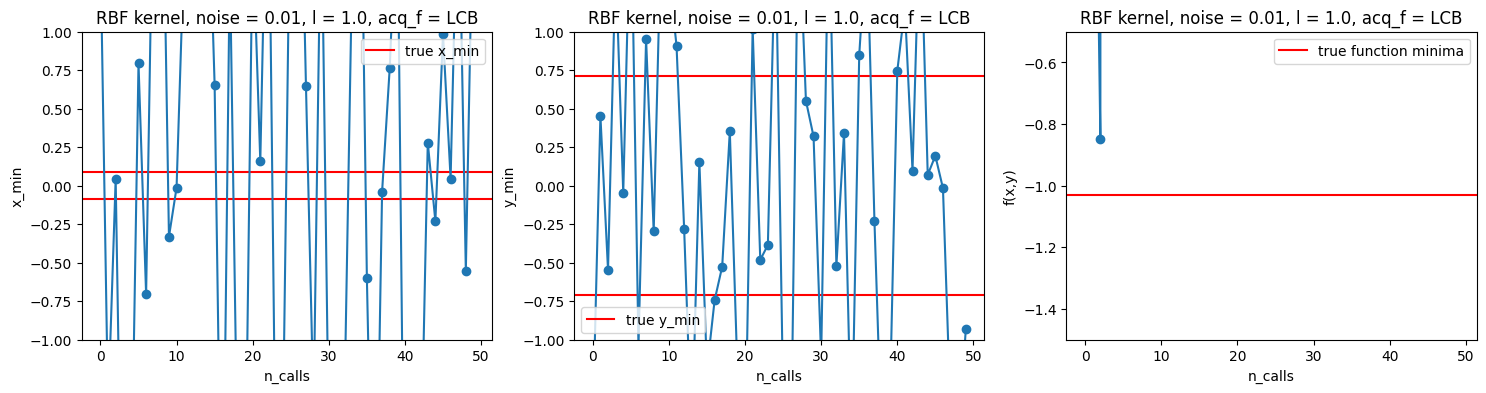

best minima location estimate [0.04308384400701115, -0.5477895914281512]
best minima value estimate -0.8476826880492819


In [82]:
ncal=50; l = 1.0; ac_f = "LCB"
rbf_optimization_six_hump_camel(noise_level,ncal,l,ac_f)

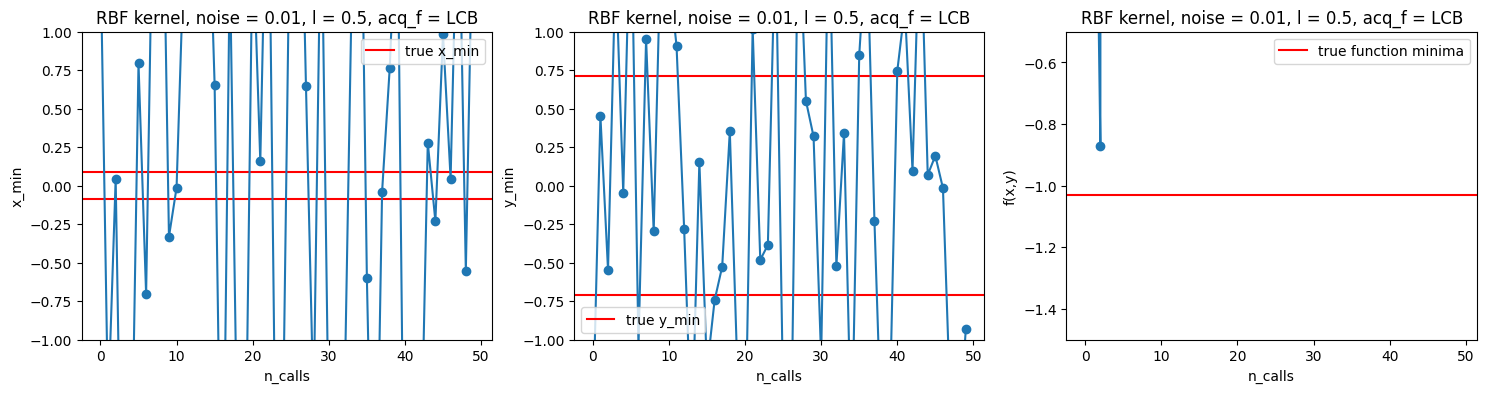

best minima location estimate [0.04308384400701115, -0.5477895914281512]
best minima value estimate -0.8700063978203436


In [83]:
ncal=50; l = 0.5; ac_f = "LCB"
rbf_optimization_six_hump_camel(noise_level,ncal,l,ac_f)

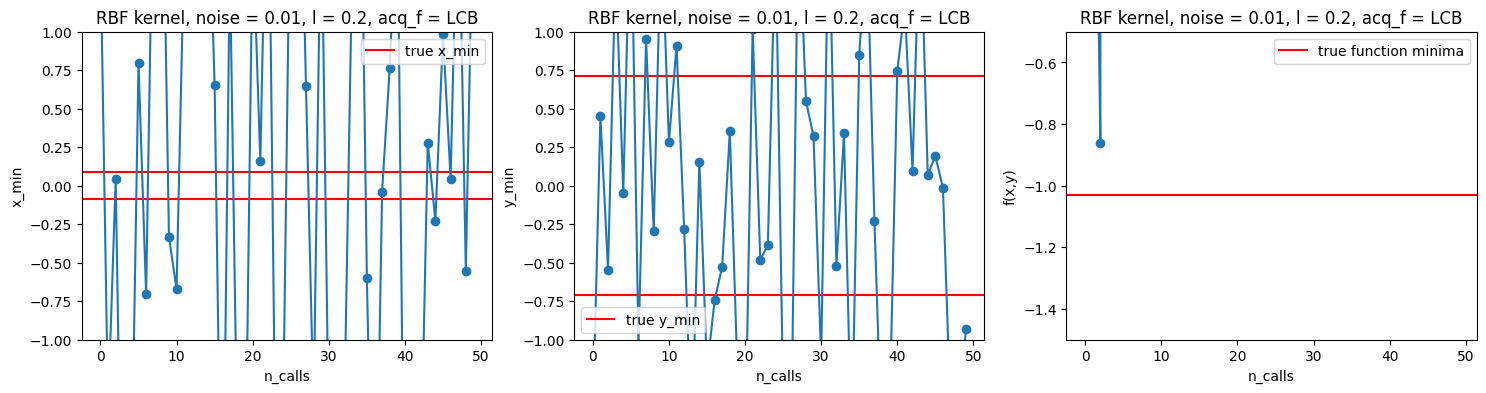

best minima location estimate [0.04308384400701115, -0.5477895914281512]
best minima value estimate -0.8605768295775252


In [84]:
ncal=50; l = 0.2; ac_f = "LCB"
rbf_optimization_six_hump_camel(noise_level,ncal,l,ac_f)

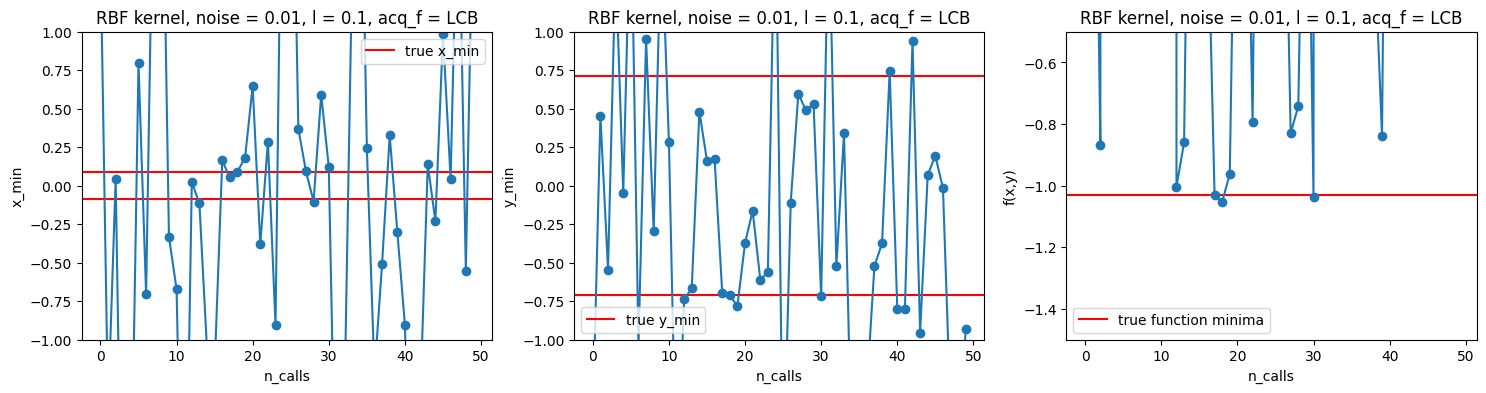

best minima location estimate [0.08981907315934734, -0.7128883606284226]
best minima value estimate -1.0531639910222728


In [85]:
ncal=50; l = 0.1; ac_f = "LCB"
rbf_optimization_six_hump_camel(noise_level,ncal,l,ac_f)

## Matern kernel results, noise = 0.01

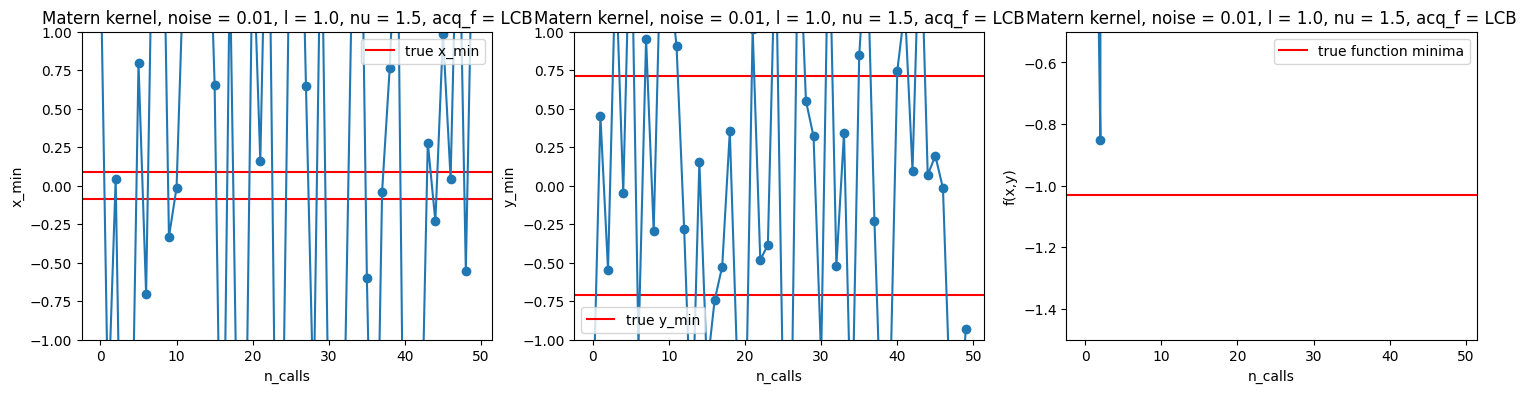

best minima location estimate [[0.04308384400701115, -0.5477895914281512]]
best minima value estimate [-0.8505464187128731]


In [86]:
ncal=50; l = 1.0; v = 1.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

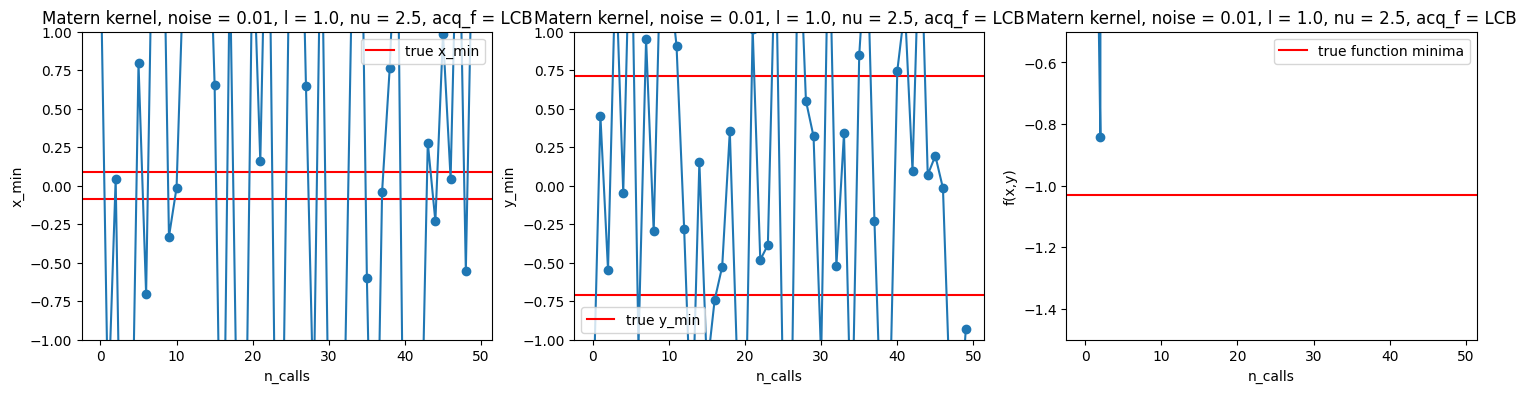

best minima location estimate [[0.04308384400701115, -0.5477895914281512]]
best minima value estimate [-0.8406679842554393]


In [87]:
ncal=50; l = 1.0; v = 2.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

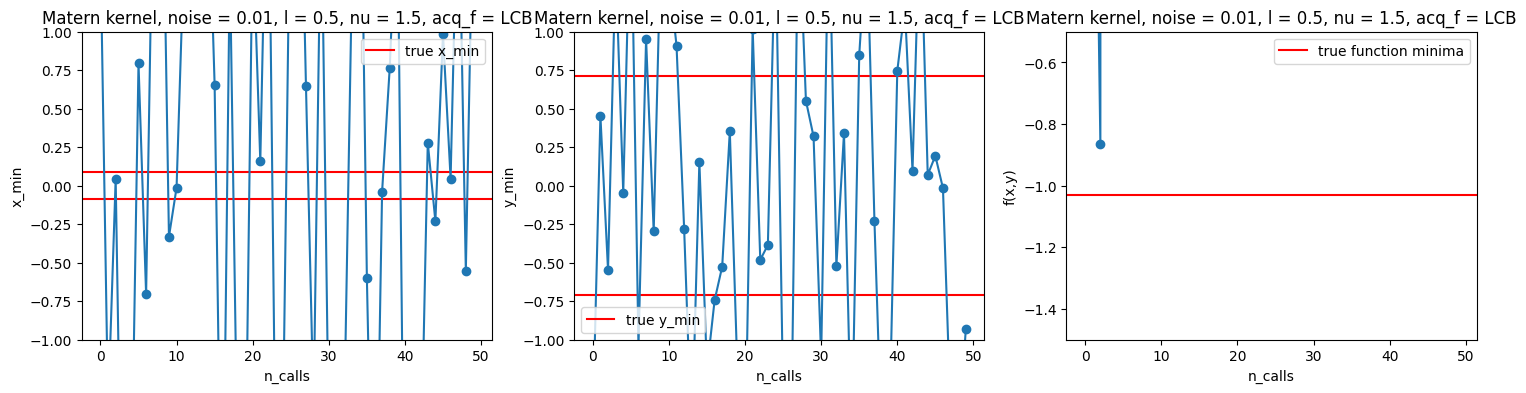

best minima location estimate [[0.04308384400701115, -0.5477895914281512]]
best minima value estimate [-0.8653365929841212]


In [88]:
ncal=50; l =0.5; v = 1.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

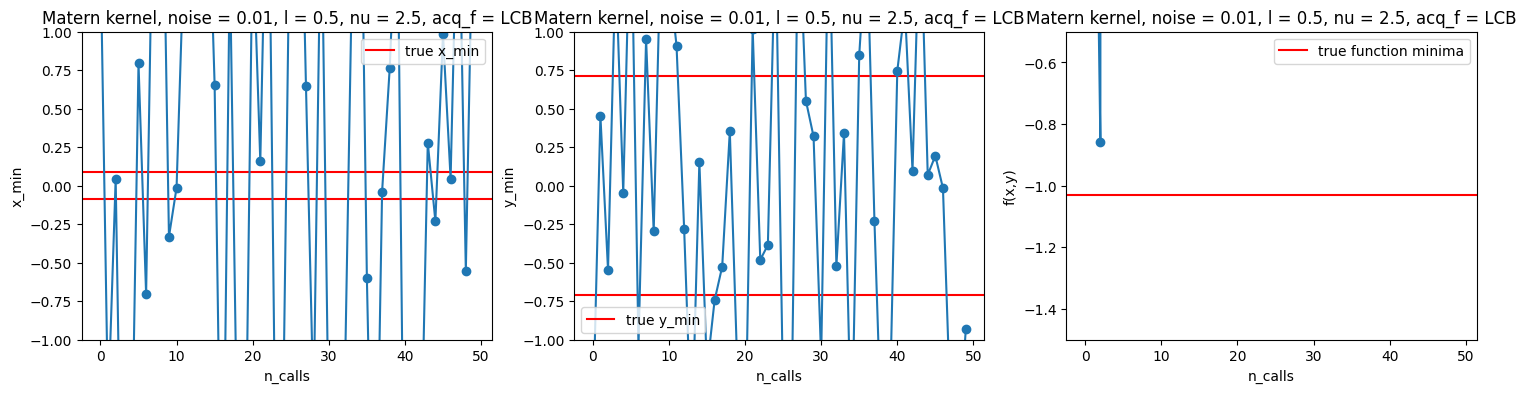

best minima location estimate [[0.04308384400701115, -0.5477895914281512]]
best minima value estimate [-0.8597101211826687]


In [89]:
ncal=50; l = 0.5; v = 2.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

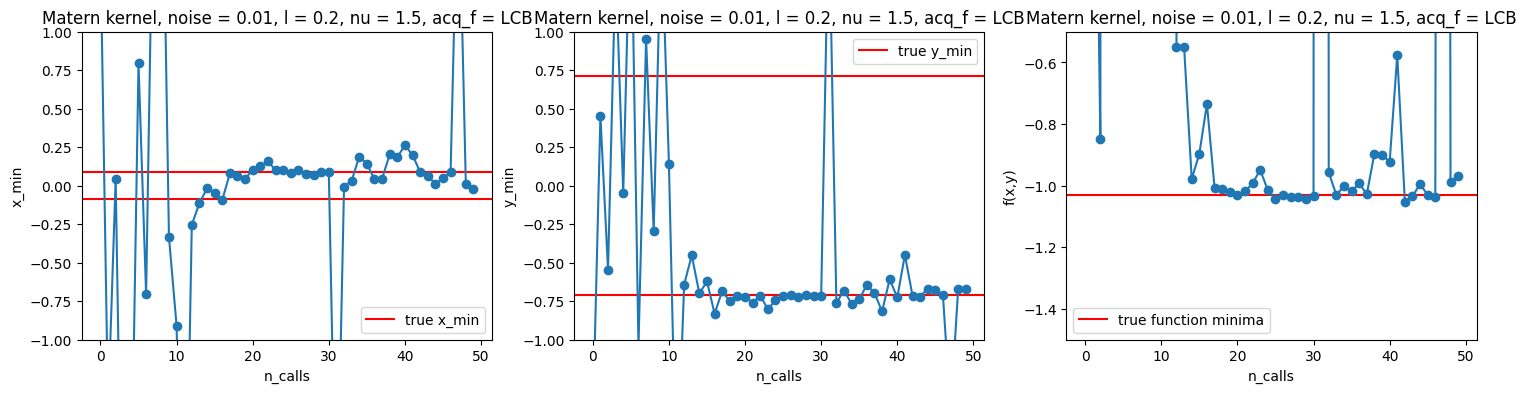

best minima location estimate [[0.08737527825385971, -0.7153691888886116]]
best minima value estimate [-1.0522943379145686]


In [90]:
ncal=50; l = 0.2; v = 1.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

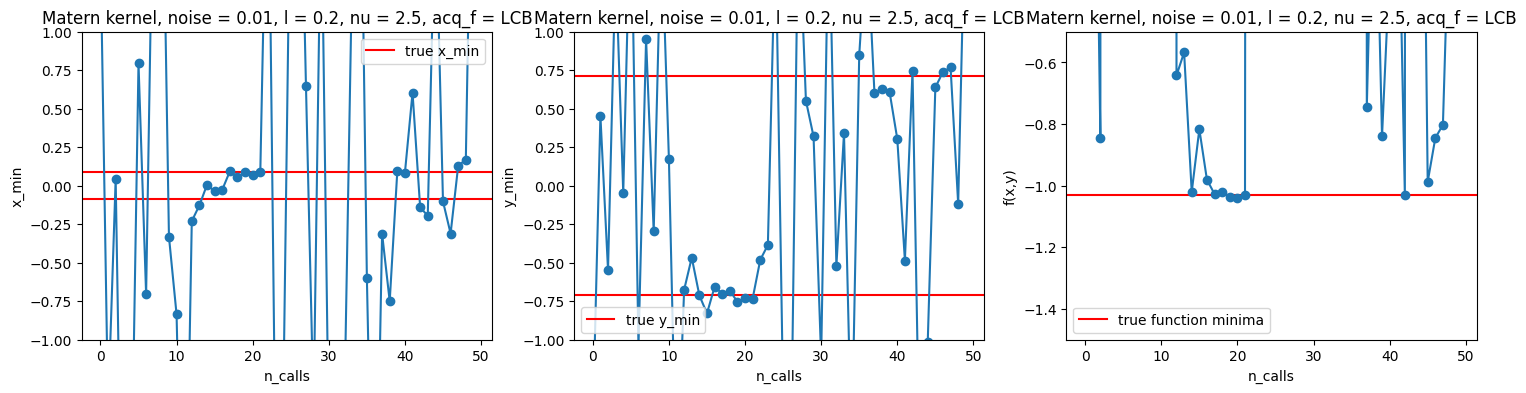

best minima location estimate [[0.06624729413064179, -0.7315100750481043]]
best minima value estimate [-1.0408606528127102]


In [91]:
ncal=50; l = 0.2; v = 2.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

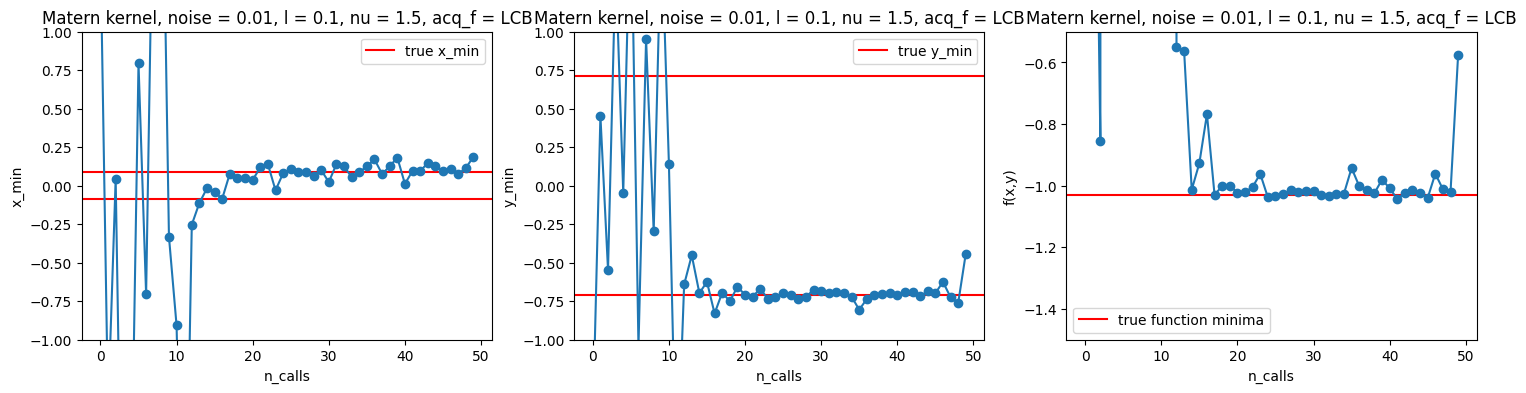

best minima location estimate [[0.09547412883770612, -0.6940230831109018]]
best minima value estimate [-1.0434295762495687]


In [92]:
ncal=50; l = 0.1; v = 1.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

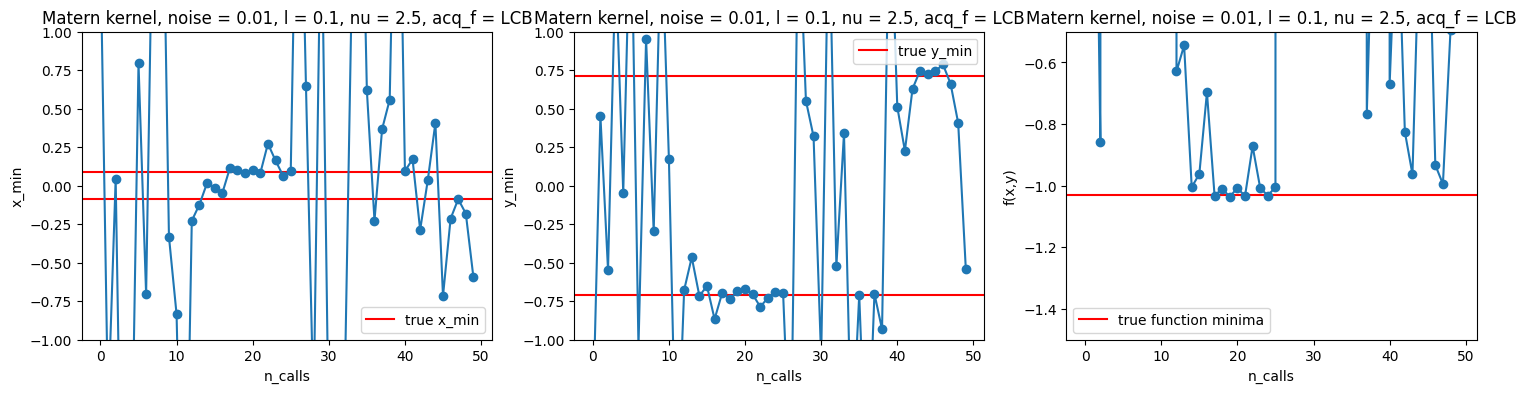

best minima location estimate [[0.07846084926304231, -0.6866293357348343]]
best minima value estimate [-1.0359808148281973]


In [93]:
ncal=50; l = 0.1; v = 2.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

# Large noise, n = 0.1. Start with the best performing kernels from previous cases

<br> $\color{red}{\text{Discussion}}$ Optimizing the six hump camel function with larger noise. Using ncalls = 50, n_restart = 10, "LCB" acquisition function with exploration/exploitation ratio = 1.96(default value from scikit gp_minimize). We use the same initial seed value for comparison, with a "sobol" sampling for even tiling of 2d space. Refer to the plots below for convergence. Configurations that get close to the function minima are highlighted in red.

RBF Kernel

| Noise level | Kernel |   Acquisition function   | l  | $x_{min}$|  $y_{min}$ | f($x_{min}$) |  
|:--------:| :---:|:------: | :----:| :----:| :-----: | :-----: | 
| 0.1        |  RBF   | LCB  |  0.1 | 0.005971556706172443 | -0.7460392727992993 |-1.0900715558282374 |
| 0.1        |  RBF   | LCB  | 0.05 | 0.02100290548570083 | -0.7389753926817637 |-1.1086250763335954 |            


Matern kernel

| Noise level | Kernel |   Acquisition function   | l  | v   | $x_{min}$|  $y_{min}$ | f($x_{min}$) |  
|:--------:| :---:|:------: | :----:| :----:| :-----:| :-----: | :-----: | 
| 0.1      |  Matern32   | LCB  | 0.2 | 1.5   | 0.07979580230383032 | -0.7164524541100274 |-1.1596849645818927 |
| 0.1      |  Matern32   | LCB  | 0.2 | 2.5   | -0.0117420954990943 | -0.7396495244485584 |-1.0668113824749659 |
| 0.1      |  Matern32   | LCB  | 0.1 | 1.5   | 0.06993069628186976 | -0.7465945902271447 |-1.194139484616926 |
| 0.1      |  Matern32   | LCB  | 0.1 | 2.5   | -0.016242244368871006 | -0.7496214869770474 |-1.1897100914084784 |
| 0.1      |  Matern32   | LCB  | 0.05 | 1.5 | -0.01571723063435515 | -0.767315627032434 | -1.1725622772736464 |
| 0.1      |  Matern32   | LCB  | 0.05 | 2.5 | 0.039677993414775514 | -0.6773591692949692 |-1.1353330950819773 |

None of the kernels can get close to the function value, due to high value of noise. Interestingly, while the RBF kernel for correlation length $l=0.1$ show rapid oscillations in the convergence plots, the Matern Kernel is marginally well behaved. The Matern kernel with $v = 2.5$ show slower oscillations compared to the RBF Kernel, while the $v=1.5$ even attains the global minima for a few iterations around the 20th iteration mark, before wandering away. For $l=0.05$, the $v=2.5$ Matern kernel showed improvement(brief exploitation phase near the function minima at 30th iteration)

## Result for RBF Kernel

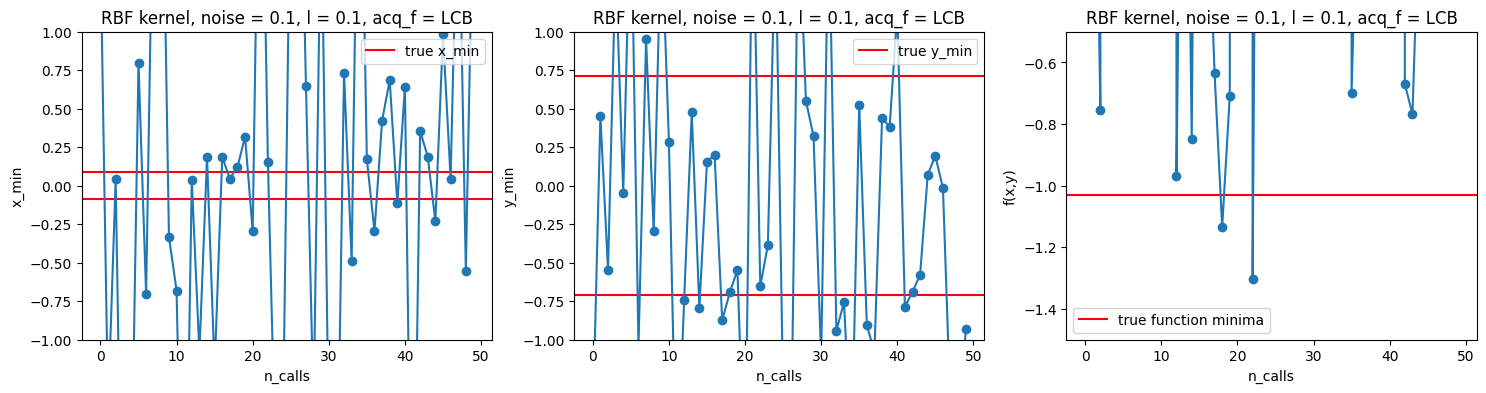

best minima location estimate [0.15407737373424535, -0.6552900602807936]
best minima value estimate -1.3022517430479084


In [107]:
ncal=50; l = 0.1; ac_f = "LCB"
rbf_optimization_six_hump_camel(noise_level,ncal,l,ac_f)

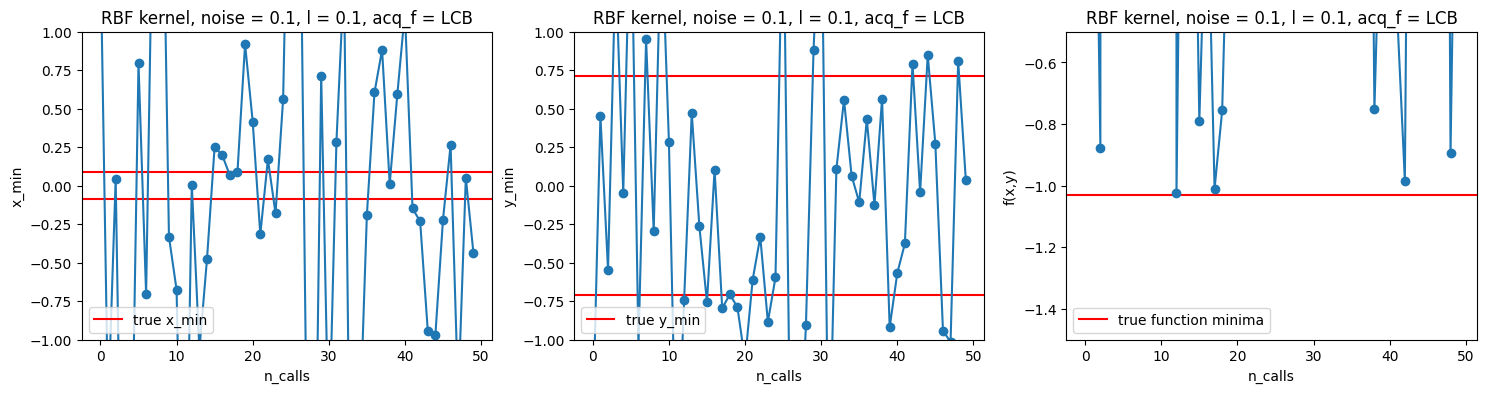

best minima location estimate [0.0066195625952243375, -0.7401547121656977]
best minima value estimate -1.0238717693102175


In [108]:
ncal=50; l = 0.05; ac_f = "LCB"
rbf_optimization_six_hump_camel(noise_level,ncal,l,ac_f)

## Result for the Matern Kernel

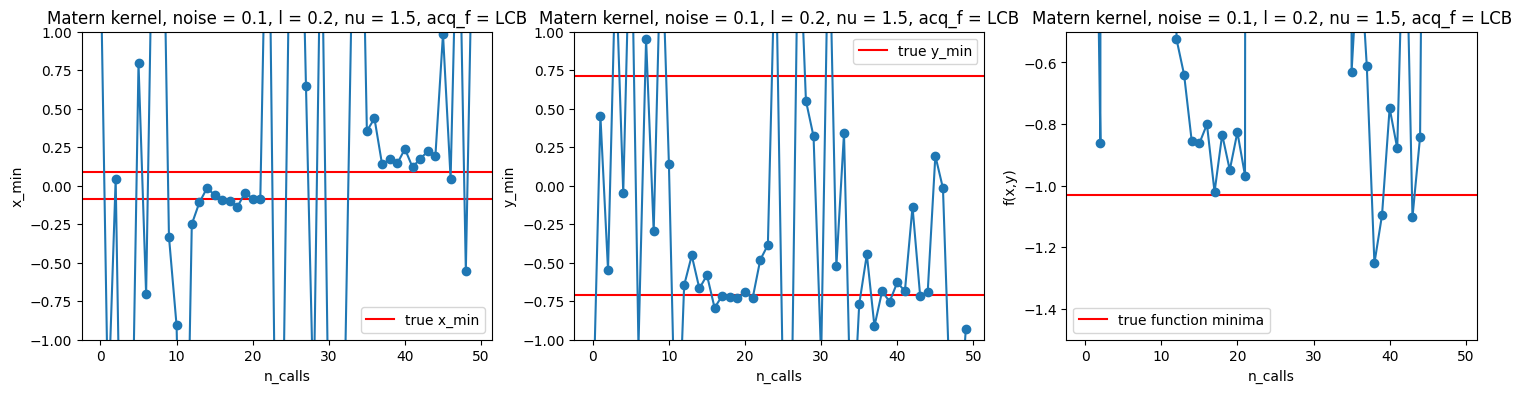

best minima location estimate [[0.17191696349579821, -0.6877745141676537]]
best minima value estimate [-1.2522158171110314]


In [109]:
ncal=50; l = 0.2; v = 1.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

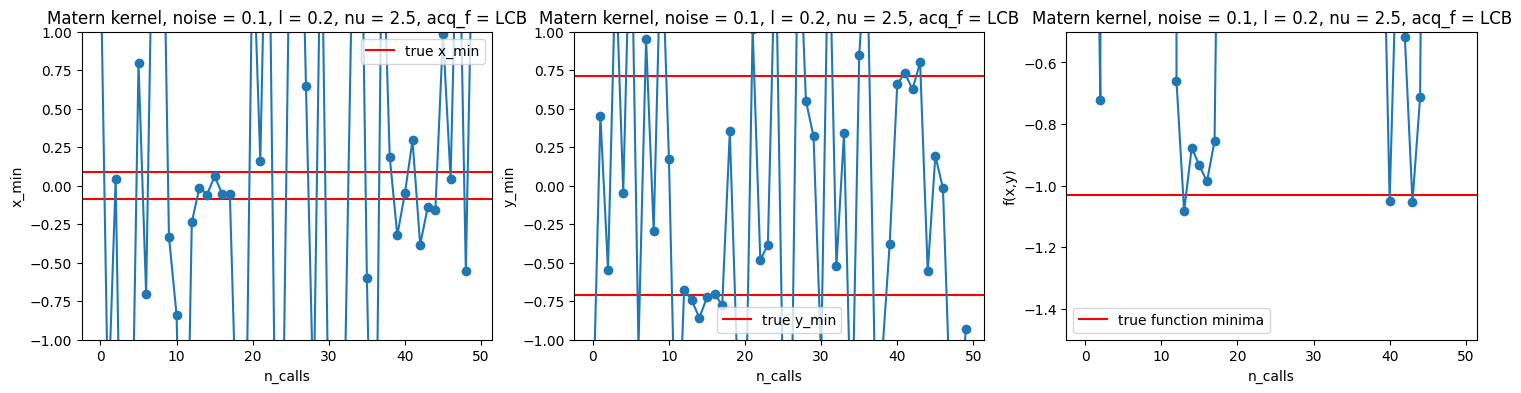

best minima location estimate [[-0.012931016328969758, -0.7459216588520605]]
best minima value estimate [-1.0827513834384312]


In [110]:
ncal=50; l = 0.2; v = 2.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

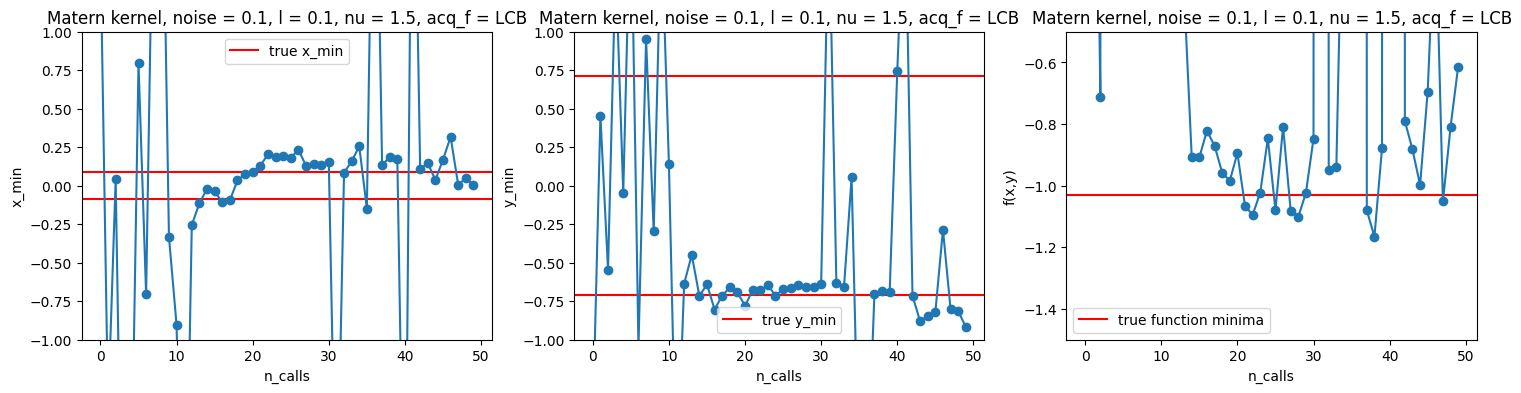

best minima location estimate [[0.18446058213577965, -0.6845571483847246]]
best minima value estimate [-1.165820875276575]


In [111]:
ncal=50; l = 0.1; v = 1.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

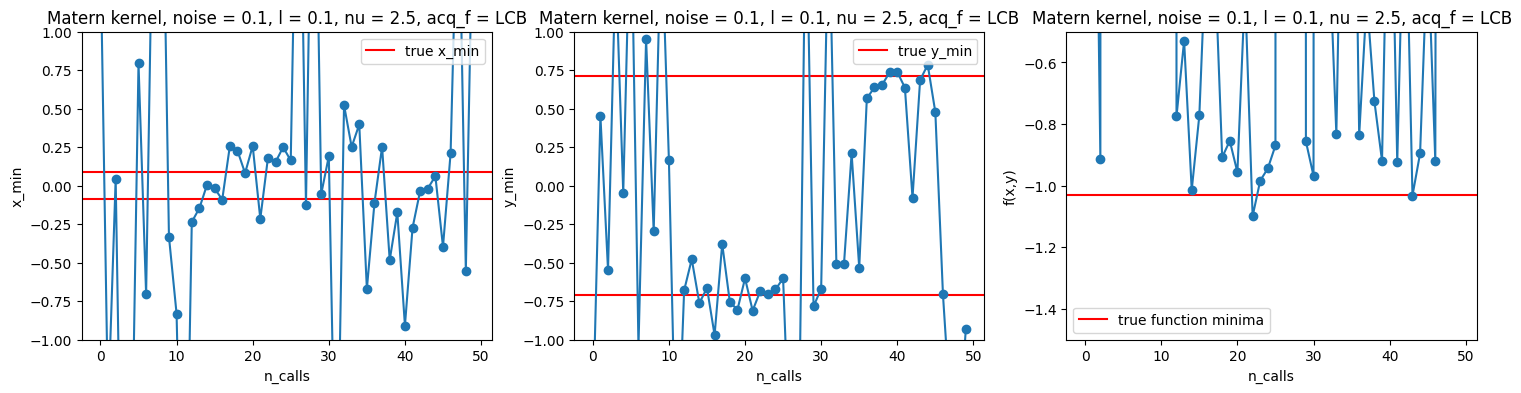

best minima location estimate [[0.17823698365279572, -0.6849119764352694]]
best minima value estimate [-1.099264971045064]


In [112]:
ncal=50; l = 0.1; v = 2.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

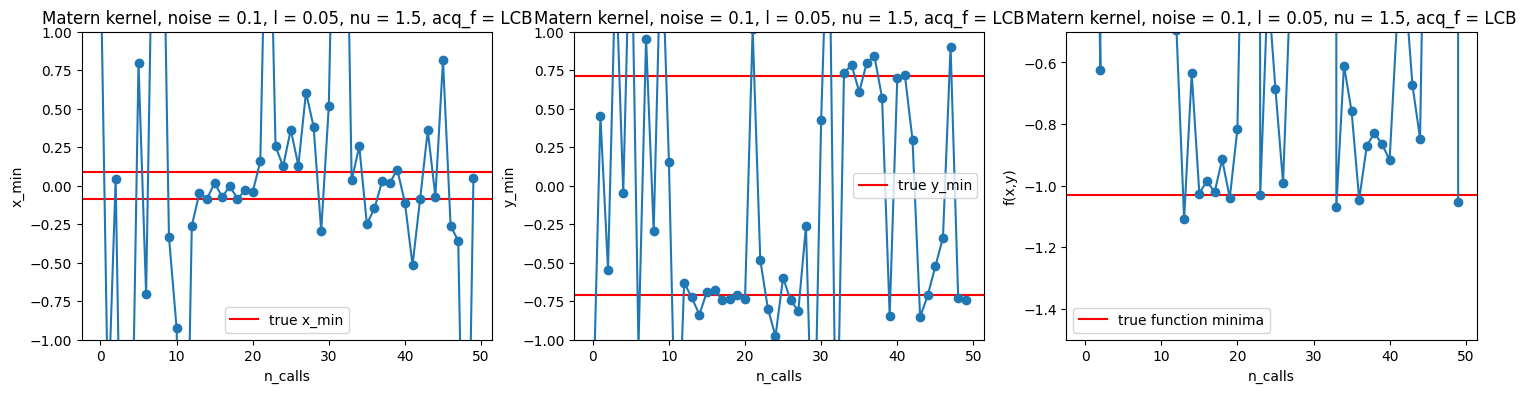

best minima location estimate [[-0.048388471603804106, -0.7267274822629601]]
best minima value estimate [-1.1099897418087552]


In [183]:
ncal=50; l = 0.05; v = 1.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

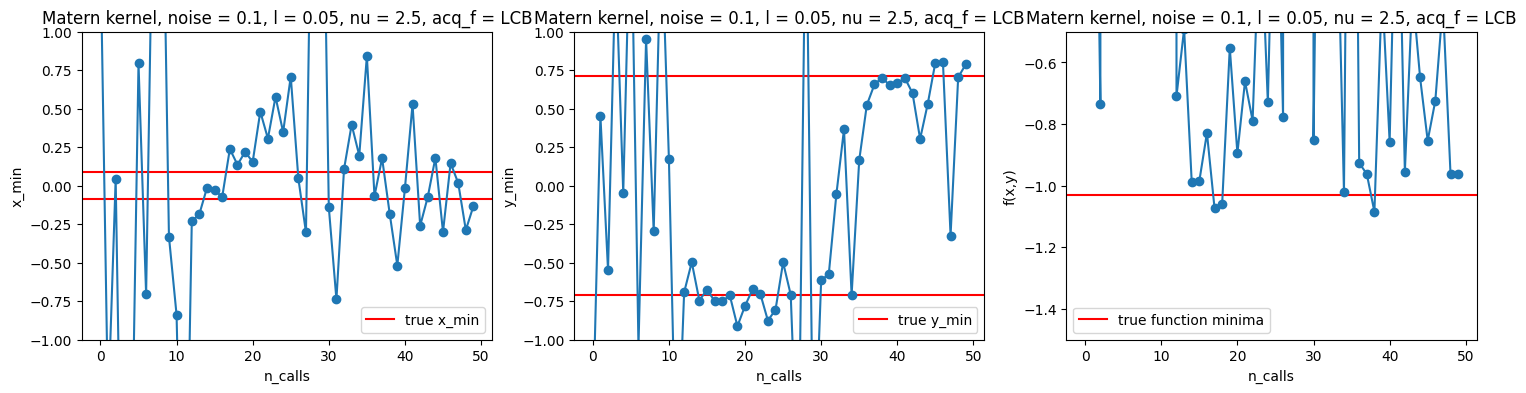

best minima location estimate [[-0.1826336685476373, 0.7010518393964755]]
best minima value estimate [-1.0851424068339277]


In [184]:
ncal=50; l = 0.05; v = 2.5; ac_f = "LCB"
matern_optimization_six_hump_camel(noise_level,ncal,l,v,ac_f)

## Test on Langermann function now

In [7]:
def langermann(x):
    """
    Langermann test objective function.
    Args: 
    x: Two-dimensional point; format: [[x0, x1]] 
    Returns: Function value 
    """
    m = 5  # Number of terms in the sum
    A = np.array([[3, 5], [5, 2], [2, 1], [1, 4], [7, 9]])  # Coefficients
    C = np.array([1, 2, 5, 2, 3])  # Exponential weights
    
    return -1*np.sum(C * np.exp(-np.sum((x - A) ** 2, axis=1) / np.pi) * np.cos(np.pi * np.sum((x - A) ** 2, axis=1)))

Text(0, 0.5, 'x2')

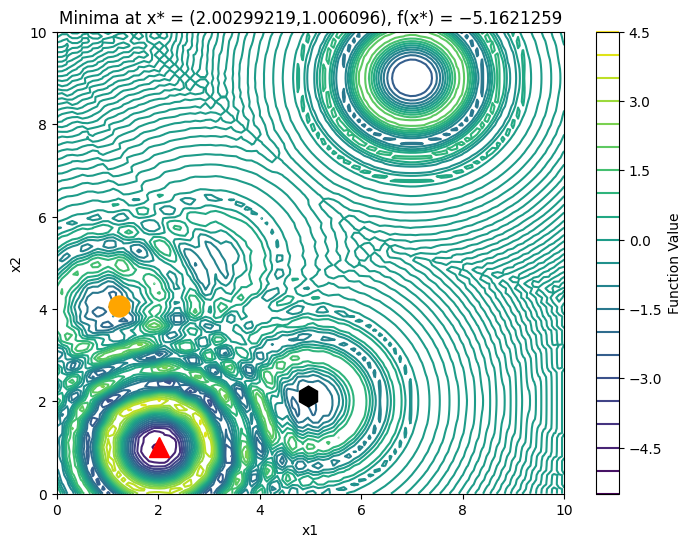

In [8]:
# Generate grid of points
x1_values = np.linspace(0, 10, 100)
x2_values = np.linspace(0, 10, 100)
X1, X2 = np.meshgrid(x1_values, x2_values)

# Evaluate Langermann function over the grid
Z = np.zeros_like(X1)
for i in range(len(x1_values)):
    for j in range(len(x2_values)):
        Z[i, j] = langermann([X1[i, j], X2[i, j]])

plt.rcParams["figure.figsize"] = (18, 6)
# Create contour plot
#Function minima and minimum value from https://glompo.readthedocs.io/en/latest/tasks/benchmarks.html#glompo.benchmark_fncs.Langermann
plt.subplot(1,2,1)
plt.title("Minima at x* = (2.00299219,1.006096), f(x*) = −5.1621259") 
contour = plt.contour(X1, X2, Z, levels=20)
plt.colorbar(contour, label='Function Value')
plt.plot(4.948370365263692, 2.1093930672684555, marker = "h", markersize = 15,color = "black") 
plt.plot(1.225337007594851, 4.061263971274012, marker = "o", markersize = 15,color = "orange") 
plt.plot(2.00299219,1.006096, marker = "^",markersize = 15, color = "red")
plt.xlabel('x1')
plt.ylabel('x2')


### Rebuild the Kernels. To explore the presence of multiple minimas in a small patch, we will focus our search in the (0,6),(0,6) region where there are multiple extremas

In [17]:
# Define the search space for Bayesian optimization
def matern_langermann_function(ncal,l,v,ac_f):

        
    matern_kernel = Matern(length_scale=l, nu=v)
    matern_gp = GaussianProcessRegressor(kernel=matern_kernel)
    space = [Real(0, 6, name='x'), Real(0, 6, name='y')]


# Perform Bayesian optimization using Gaussian Process regression
    res2d_matern = gp_minimize(langermann, 
                  space,      # the bounds on each dimension of x
                  initial_point_generator = "sobol", #initial point generator
                  acq_func=ac_f,      # the acquisition function
                  n_calls=ncal,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=1e-10,       # the noise level = our selected noise, we set it to 10**-10 if there is no noise.0 causes issues
                  random_state=1234,base_estimator=matern_gp)   # the random seed

    x_iteration = [res2d_matern.x_iters[i][0] for i in range(len(res2d_matern.x_iters))]
    y_iteration = [res2d_matern.x_iters[i][1] for i in range(len(res2d_matern.x_iters))]

    function_val = res2d_matern.func_vals

    plt.rcParams["figure.figsize"] = (18, 4)
    plt.subplot(1, 3, 1)
    plt.title("Matern kernel, l = %s, nu = %s, acq_f = %s"%(str(round(l,1)),str(round(v,1)),ac_f))
    plt.ylabel("x_min")
    plt.xlabel("n_calls")
    plt.axhline(y=2.00299219,c='red',label="global x_min")
    plt.plot(x_iteration,marker="o")
    plt.legend(loc='best')
    
    plt.subplot(1, 3, 2)
    plt.title("Matern kernel, l = %s, nu = %s, acq_f = %s"%(str(round(l,1)),str(round(v,1)),ac_f))
    plt.ylabel("y_min")
    plt.xlabel("n_calls")
    plt.axhline(y=1.006096,c='red', label = "global y_min")
    plt.plot(y_iteration,marker="o")
    plt.legend(loc="best")
    
    plt.subplot(1, 3, 3)
    plt.title("Matern kernel, l = %s, nu = %s, acq_f = %s"%(str(round(l,1)),str(round(v,1)),ac_f))
    plt.ylabel("f(x,y)")
    plt.xlabel("n_calls")
    plt.axhline(y = -5.1621259, label = "global function minima")
    plt.plot(function_val,marker="o")
    plt.legend(loc = 'best')
    plt.show()
    
    best_params = res2d_matern.x
    best_score = res2d_matern.fun
    print("Best parameters:", best_params)
    print("Best score:", best_score)

<br> $\color{red}{\text{Discussion}}$ Optimizing the noiseless Langermann function. Using ncalls = 65, n_restart = 10, "LCB" acquisition function with exploration/exploitation ratio = 1.96(default value from scikit gp_minimize). We use the same initial seed value for comparison, with a "sobol" sampling for even tiling of 2d space. Refer to the plots below for convergence. We try to reach the global minima at 2.00299219,1.006096


Matern kernel

| Noise level | Kernel |   Acquisition function   | l  | v   | $x_{min}$|  $y_{min}$ | f($x_{min}$) |  
|:--------:| :---:|:------: | :----:| :----:| :-----:| :-----: | :-----: | 
| 0.1      |  Matern32   | LCB  | 0.5 | 1.5   | 4.948370365263692 | 2.1093930672684555 | -2.20957280665125 |
| 0.1      |  Matern32   | LCB  | 0.5 | 2.5   | 1.225337007594851 | 4.061263971274012 | -2.4211241564758827 |
| 0.1      |  Matern32   | LCB  | 0.2 | 1.5   | 4.949983190883221 | 2.136470035830221 | -2.207300064183213  |
| 0.1      |  Matern32   | LCB  | 0.2 | 2.5   | 1.2253339032564883 | 4.061268017485894 | -2.4211241566691157 |
| 0.1      |  Matern32   | LCB  | 0.1 | 1.5   | 4.956285573374438  | 2.108663636756158 |-2.211690803011327 |
| 0.1      |  Matern32   | LCB  | 0.1 | 2.5   | 1.2253245649690927 | 4.061273504724617 |-2.421124152229256 |

The Matern kernel shows an interesting behavior. While the optimizer cannot go to the global minima, it always lands in the secondary minima, and the convergence plots show a good range of exploitative region after 20-30 iterations. For smoothness parameter $v = 1.5$, we always land close to the secondary minima near (5,2.1) (gp_minimize point marked by black hexagon), while for $v=2.5$, we reach the near the other minima (1.22,4.06, point marked by orange dot)  

In order to go to the global minima, we will shrink the search space to $x \in [0,4], y \in [0,4]$

### Results with Matern Kernel

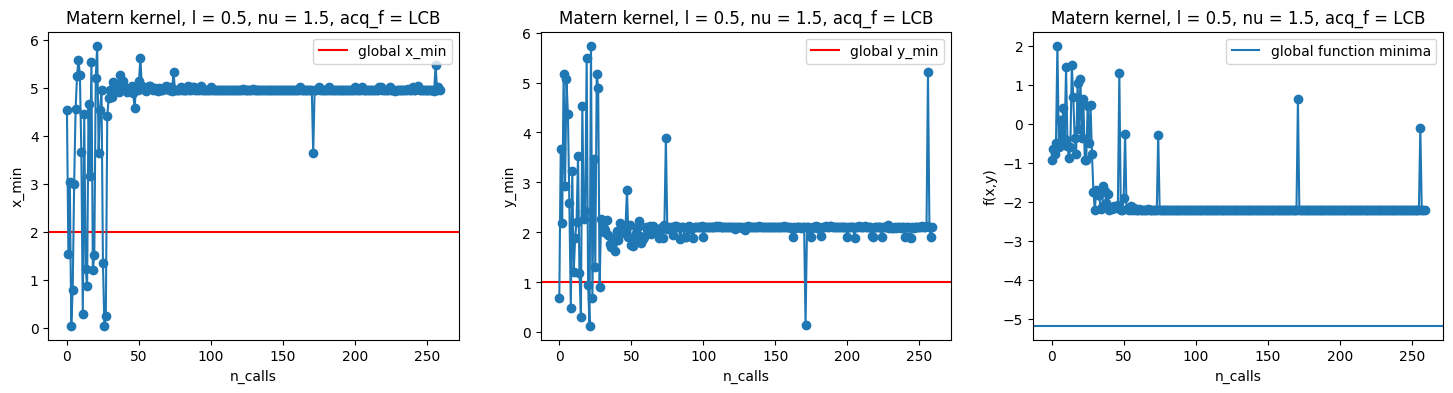

Best parameters: [4.955918866222581, 2.109223639038475]
Best score: -2.211693606145891


In [18]:
ncal = 260; l = 0.5; v = 1.5; ac_f = "LCB"
matern_langermann_function(ncal,l,v,ac_f)

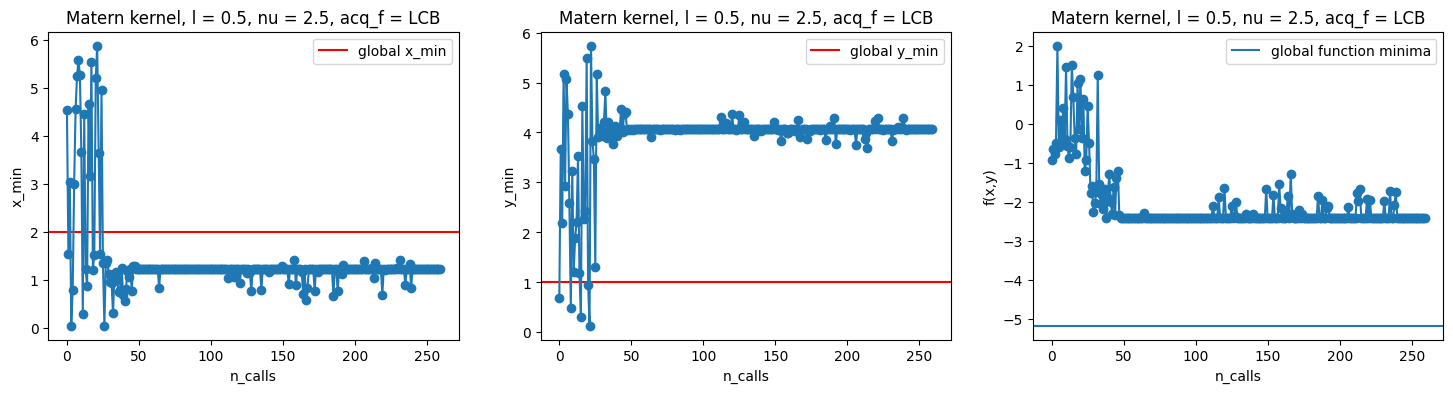

Best parameters: [1.2253339003967045, 4.061265893555384]
Best score: -2.4211241568666657


In [19]:
ncal = 260; l = 0.5; v = 2.5; ac_f = "LCB"
matern_langermann_function(ncal,l,v,ac_f)

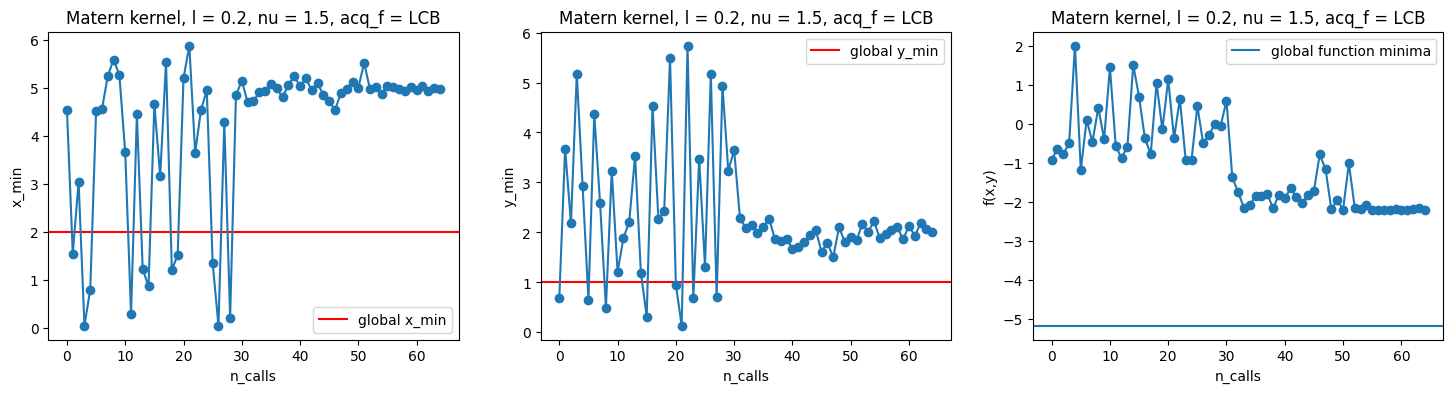

Best parameters: [4.949983190883221, 2.136470035830221]
Best score: -2.207300064183213


In [146]:
ncal = 65; l = 0.2; v = 1.5; ac_f = "LCB"
matern_langermann_function(ncal,l,v,ac_f)

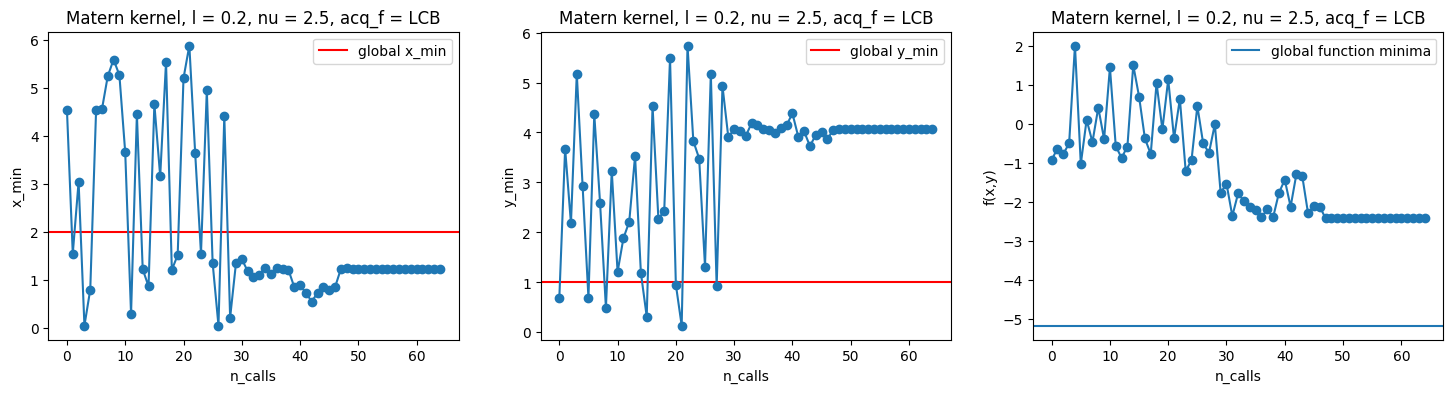

Best parameters: [1.2253339032564883, 4.061268017485894]
Best score: -2.4211241566691157


In [150]:
ncal = 65; l = 0.2; v = 2.5; ac_f = "LCB"
matern_langermann_function(ncal,l,v,ac_f)

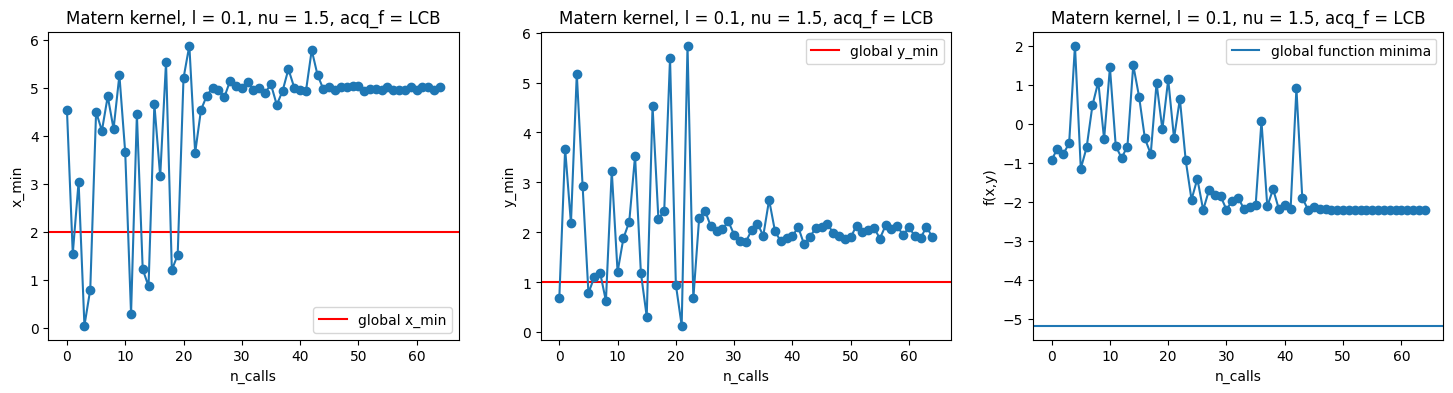

Best parameters: [4.956285573374438, 2.108663636756158]
Best score: -2.211690803011327


In [148]:
ncal = 65; l = 0.1; v = 1.5; ac_f = "LCB"
matern_langermann_function(ncal,l,v,ac_f)

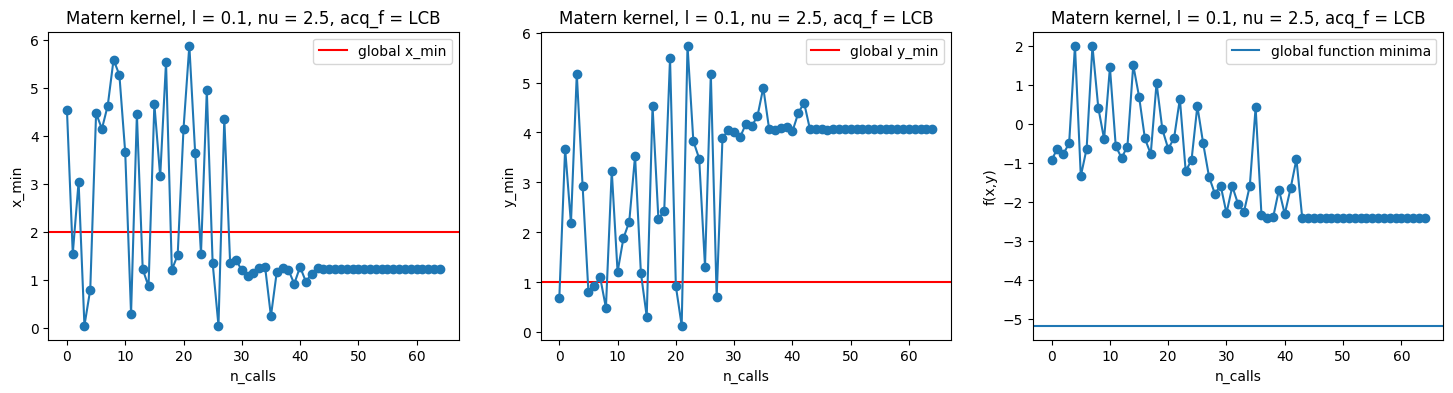

Best parameters: [1.2253245649690927, 4.061273504724617]
Best score: -2.421124152229256


In [149]:
ncal = 65; l = 0.1; v = 2.5; ac_f = "LCB"
matern_langermann_function(ncal,l,v,ac_f)

## Let's constrain the search space to (0,4),(0,4)

In [172]:
def matern_constrained_langermann_function(ncal,l,v,ac_f):

        
    matern_kernel = Matern(length_scale=l, nu=v)
    matern_gp = GaussianProcessRegressor(kernel=matern_kernel)
    space = [Real(0, 4, name='x'), Real(0, 4, name='y')]


# Perform Bayesian optimization using Gaussian Process regression
    res2d_matern = gp_minimize(langermann, 
                  space,      # the bounds on each dimension of x
                  initial_point_generator = "sobol", #initial point generator
                  acq_func=ac_f,      # the acquisition function
                  n_calls=ncal,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=1e-10,       # the noise level = our selected noise, we set it to 10**-10 if there is no noise.0 causes issues
                  random_state=1234,base_estimator=matern_gp)   # the random seed

    x_iteration = [res2d_matern.x_iters[i][0] for i in range(len(res2d_matern.x_iters))]
    y_iteration = [res2d_matern.x_iters[i][1] for i in range(len(res2d_matern.x_iters))]

    function_val = res2d_matern.func_vals

    plt.rcParams["figure.figsize"] = (18, 4)
    plt.subplot(1, 3, 1)
    plt.title("Matern kernel, l = %s, nu = %s, acq_f = %s"%(str(round(l,1)),str(round(v,1)),ac_f))
    plt.ylabel("x_min")
    plt.xlabel("n_calls")
    plt.axhline(y=2.00299219,c='red',label="global x_min")
    plt.plot(x_iteration,marker="o")
    plt.legend(loc='best')
    
    plt.subplot(1, 3, 2)
    plt.title("Matern kernel, l = %s, nu = %s, acq_f = %s"%(str(round(l,1)),str(round(v,1)),ac_f))
    plt.ylabel("y_min")
    plt.xlabel("n_calls")
    plt.axhline(y=1.006096,c='red', label = "global y_min")
    plt.plot(y_iteration,marker="o")
    plt.legend(loc="best")
    
    plt.subplot(1, 3, 3)
    plt.title("Matern kernel, l = %s, nu = %s, acq_f = %s"%(str(round(l,1)),str(round(v,1)),ac_f))
    plt.ylabel("f(x,y)")
    plt.xlabel("n_calls")
    plt.axhline(y = -5.1621259, label = "global function minima")
    plt.plot(function_val,marker="o")
    plt.legend(loc = 'best')
    plt.show()
    
    best_params = res2d_matern.x
    best_score = res2d_matern.fun
    print("Best parameters:", best_params)
    print("Best score:", best_score)

<br> $\color{red}{\text{Discussion}}$ Optimizing the noiseless Langermann function. Using ncalls = 65, n_restart = 10, "LCB" acquisition function with exploration/exploitation ratio = 1.96(default value from scikit gp_minimize). We use the same initial seed value for comparison, with a "sobol" sampling for even tiling of 2d space. Refer to the plots below for convergence. We try to reach the global minima at 2.00299219,1.006096


Matern kernel

| Noise level | Kernel |   Acquisition function   | l  | v   | $x_{min}$|  $y_{min}$ | f($x_{min}$) |  
|:--------:| :---:|:------: | :----:| :----:| :-----:| :-----: | :-----: | 
| 0.1      |  Matern32   | LCB  | 0.5 | 1.5   | 2.003791916290326 | 1.0054906002622233 | -5.162108099000094 |
| 0.1      |  Matern32   | LCB  | 0.5 | 2.5   | 2.002999138746236 | 1.0060891626208892 | -5.16212615826875 |
| 0.1      |  Matern32   | LCB  | 0.2 | 1.5   | 2.0022602776857874 | 1.0057829427907576 | -5.162115031268057 |
| 0.1      |  Matern32   | LCB  | 0.2 | 2.5   | 2.0029887470461687 | 1.0060916019735537 | -5.162126159456048 |
| 0.1      |  Matern32   | LCB  | 0.1 | 1.5   | 2.0029921673542703 | 1.0060958835614837 | -5.1621261599638855 |
| 0.1      |  Matern32   | LCB  | 0.1 | 2.5   | 2.0029938420813282 | 1.006093335654475 | -5.162126159793606 |

The Matern kernel reached the global minima for all the configs shown above. An interesting behavior is seen from the convergence plots. The smoothness parameter $v$ doesn't effect the convergence time at all in terms of exploration/exploitation time spent. For correlation length $l = 0.5,0.2$, the optimum value is reached around 25th iteration, however, shortening it to $l=0.1$ results in a quicker convergence after 10th iterations.

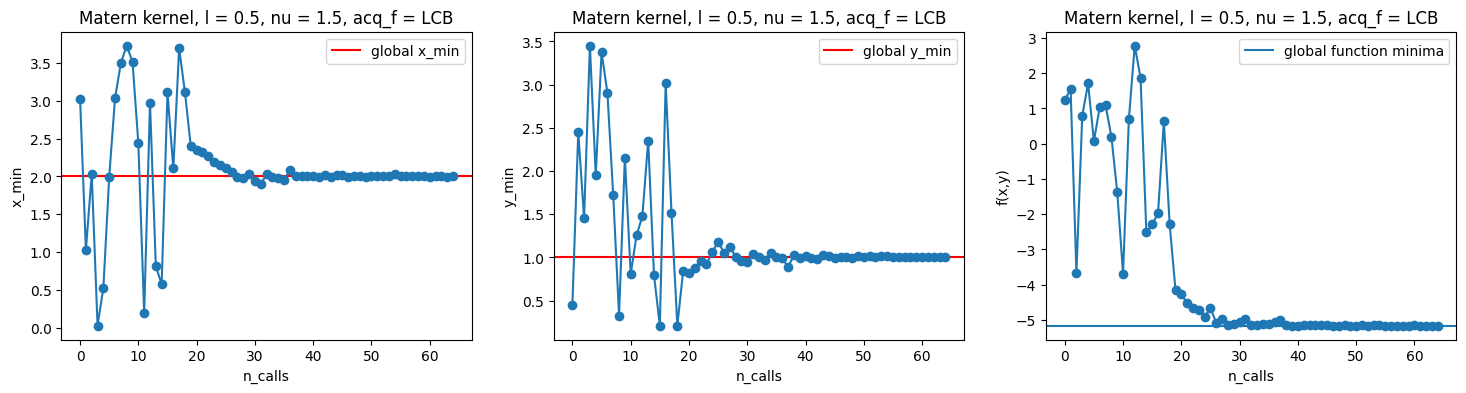

Best parameters: [2.003791916290326, 1.0054906002622233]
Best score: -5.162108099000094


In [173]:
Ncal=65; l=0.5; v=1.5; ac_f="LCB"
matern_constrained_langermann_function(ncal,l,v,ac_f)

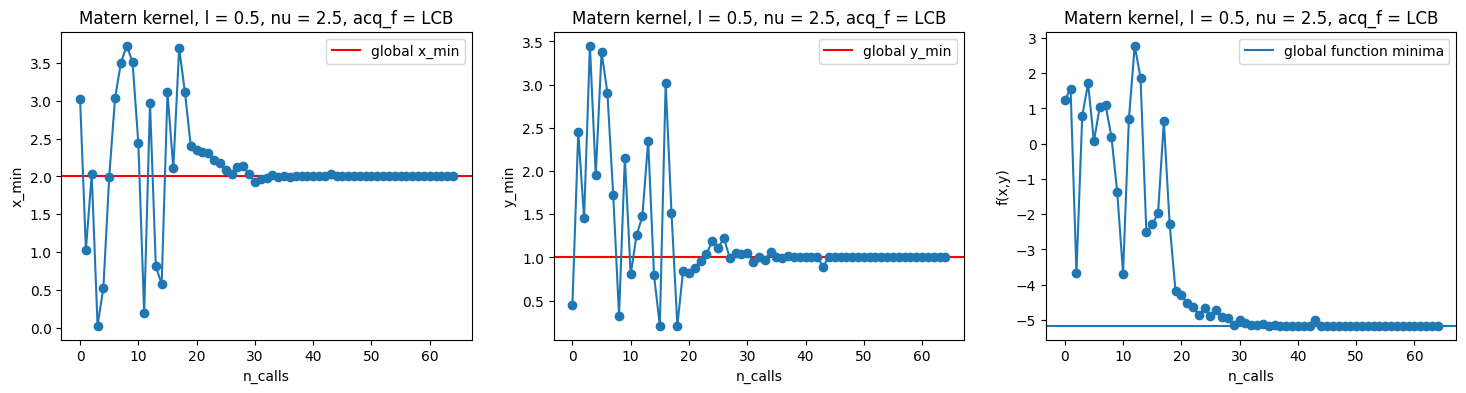

Best parameters: [2.002999138746236, 1.0060891626208892]
Best score: -5.16212615826875


In [174]:
Ncal=65; l=0.5; v=2.5; ac_f="LCB"
matern_constrained_langermann_function(ncal,l,v,ac_f)

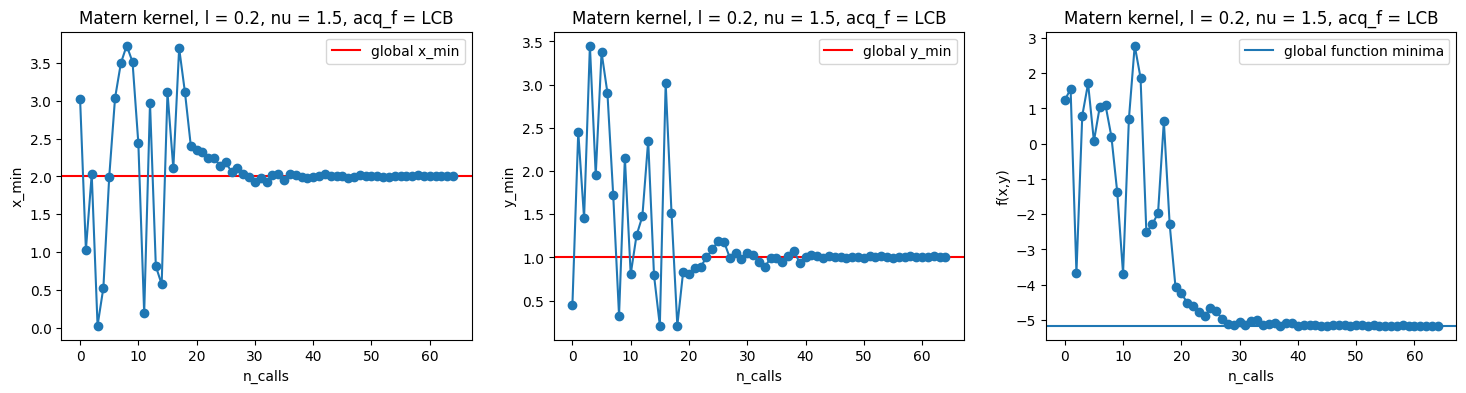

Best parameters: [2.0022602776857874, 1.0057829427907576]
Best score: -5.162115031268057


In [175]:
Ncal=65; l=0.2; v=1.5; ac_f="LCB"
matern_constrained_langermann_function(ncal,l,v,ac_f)

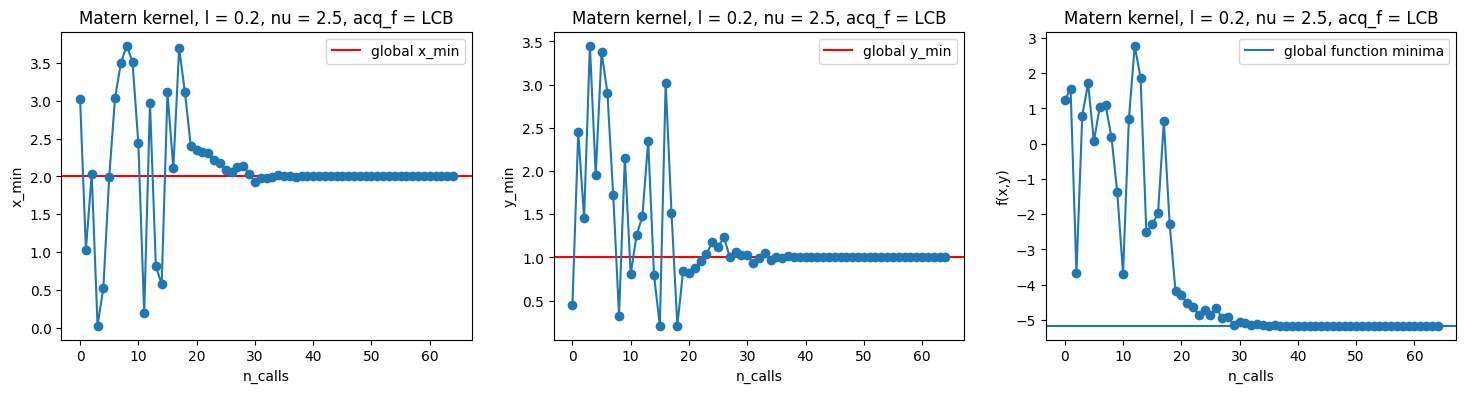

Best parameters: [2.0029887470461687, 1.0060916019735537]
Best score: -5.162126159456048


In [176]:
Ncal=65; l=0.2; v=2.5; ac_f="LCB"
matern_constrained_langermann_function(ncal,l,v,ac_f)

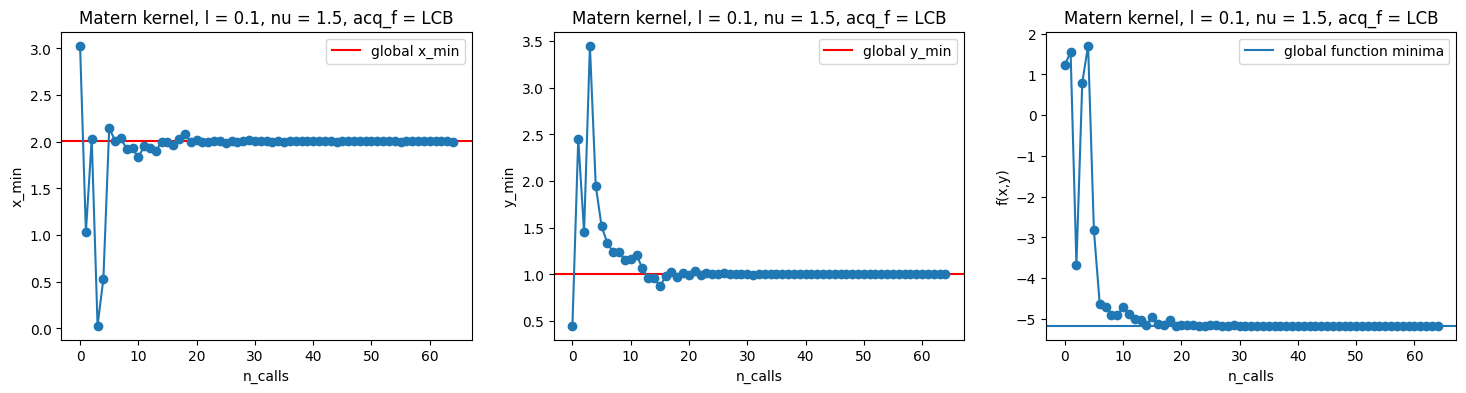

Best parameters: [2.0029921673542703, 1.0060958835614837]
Best score: -5.1621261599638855


In [177]:
Ncal=65; l=0.1; v=1.5; ac_f="LCB"
matern_constrained_langermann_function(ncal,l,v,ac_f)

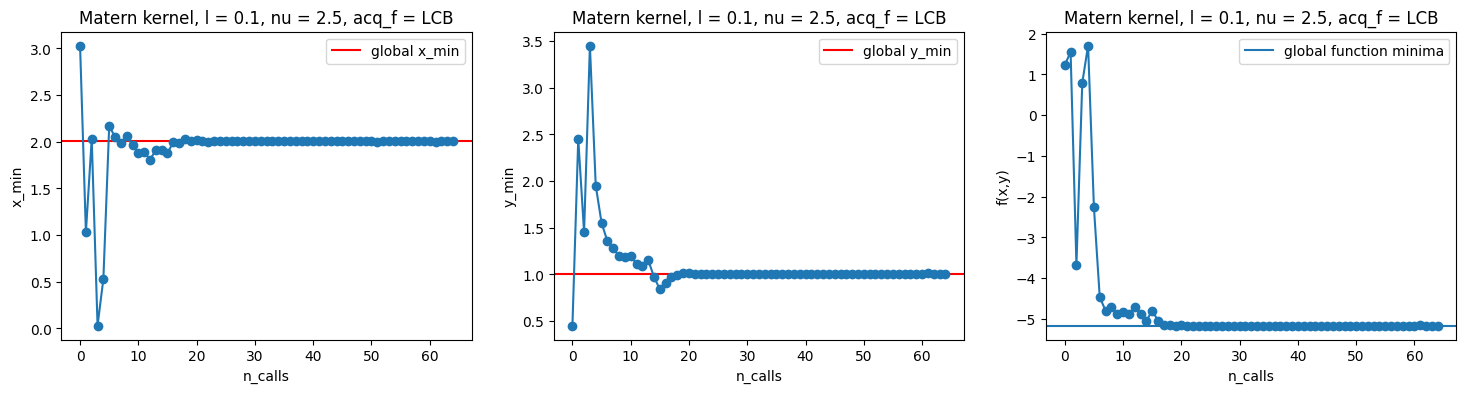

Best parameters: [2.0029938420813282, 1.006093335654475]
Best score: -5.162126159793606


In [178]:
Ncal=65; l=0.1; v=2.5; ac_f="LCB"
matern_constrained_langermann_function(ncal,l,v,ac_f)

### Modify the optimizer to include the exploration exploitation parameter

In [22]:
def modified_matern_langermann_function(ncal,l,v,ac_f,kap):

        
    matern_kernel = Matern(length_scale=l, nu=v)
    matern_gp = GaussianProcessRegressor(kernel=matern_kernel)
    space = [Real(0, 6, name='x'), Real(0, 6, name='y')]


# Perform Bayesian optimization using Gaussian Process regression
    res2d_matern = gp_minimize(langermann, 
                  space,      # the bounds on each dimension of x
                  initial_point_generator = "sobol", #initial point generator
                  acq_func=ac_f,      # the acquisition function
                  n_calls=ncal,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=1e-10,       # the noise level = our selected noise, we set it to 10**-10 if there is no noise.0 causes issues
                  random_state=1234,base_estimator=matern_gp,kappa=kap)   # the random seed

    x_iteration = [res2d_matern.x_iters[i][0] for i in range(len(res2d_matern.x_iters))]
    y_iteration = [res2d_matern.x_iters[i][1] for i in range(len(res2d_matern.x_iters))]

    function_val = res2d_matern.func_vals

    plt.rcParams["figure.figsize"] = (18, 4)
    plt.subplot(1, 3, 1)
    plt.title("Matern kernel, l = %s, nu = %s, acq_f = %s"%(str(round(l,1)),str(round(v,1)),ac_f))
    plt.ylabel("x_min")
    plt.xlabel("n_calls")
    plt.axhline(y=2.00299219,c='red',label="global x_min")
    plt.plot(x_iteration,marker="o")
    plt.legend(loc='best')
    
    plt.subplot(1, 3, 2)
    plt.title("Matern kernel, l = %s, nu = %s, acq_f = %s"%(str(round(l,1)),str(round(v,1)),ac_f))
    plt.ylabel("y_min")
    plt.xlabel("n_calls")
    plt.axhline(y=1.006096,c='red', label = "global y_min")
    plt.plot(y_iteration,marker="o")
    plt.legend(loc="best")
    
    plt.subplot(1, 3, 3)
    plt.title("Matern kernel, l = %s, nu = %s, acq_f = %s"%(str(round(l,1)),str(round(v,1)),ac_f))
    plt.ylabel("f(x,y)")
    plt.xlabel("n_calls")
    plt.axhline(y = -5.1621259, label = "global function minima")
    plt.plot(function_val,marker="o")
    plt.legend(loc = 'best')
    plt.show()
    
    best_params = res2d_matern.x
    best_score = res2d_matern.fun
    print("Best parameters:", best_params)
    print("Best score:", best_score)

## Test out the Matern 3/2 kernel on the (0,6),(0,6) space

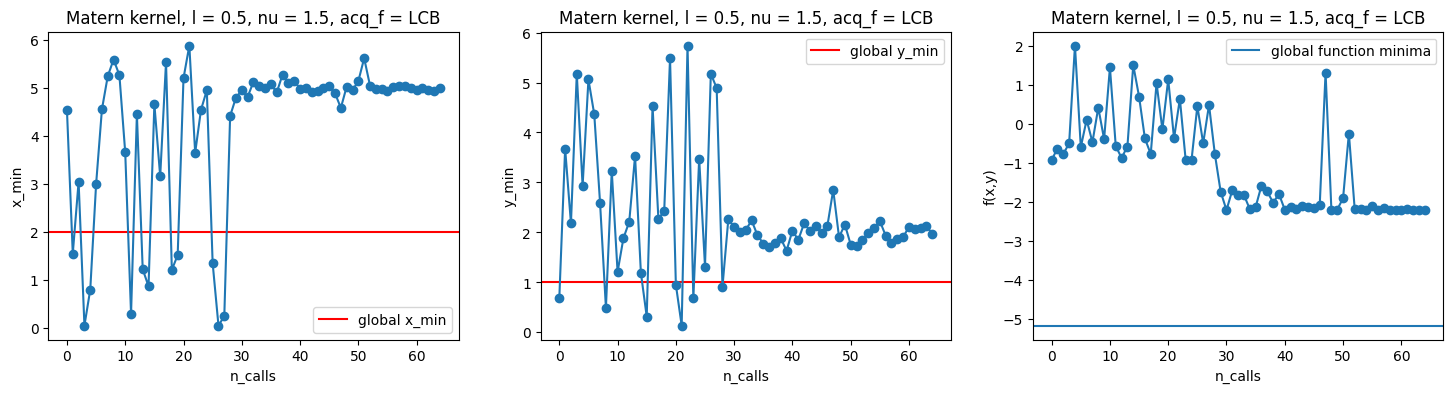

Best parameters: [4.948370365263692, 2.1093930672684555]
Best score: -2.20957280665125


In [28]:
Ncal=65; l=0.5; v=1.5; ac_f="LCB"; kap = 1.96
modified_matern_langermann_function(Ncal,l,v,ac_f,kap)

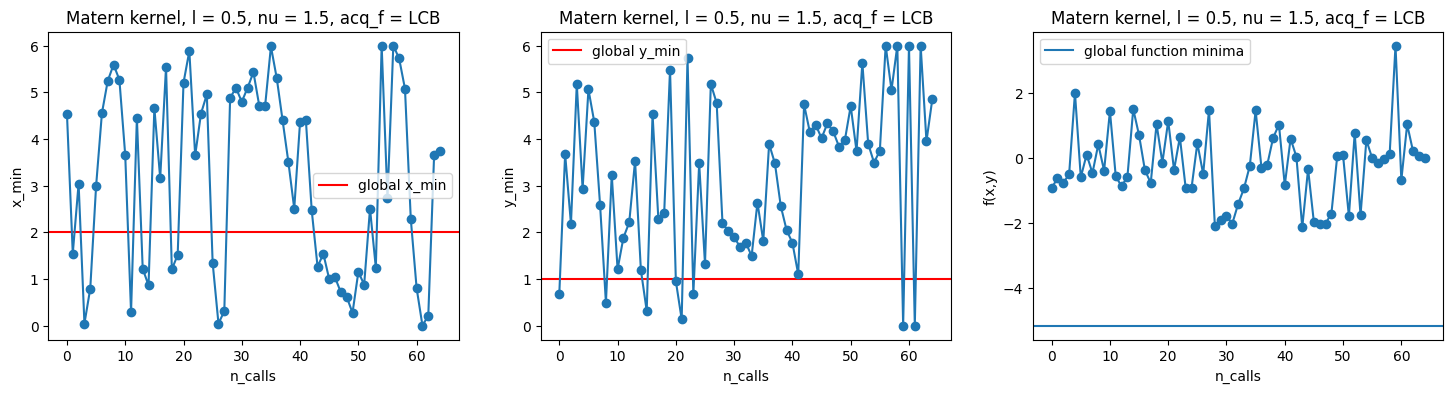

Best parameters: [1.2631459126085078, 4.140061259394716]
Best score: -2.1409455843813117


In [29]:
Ncal=65; l=0.5; v=1.5; ac_f="LCB"; kap = 3.92
modified_matern_langermann_function(Ncal,l,v,ac_f,kap)

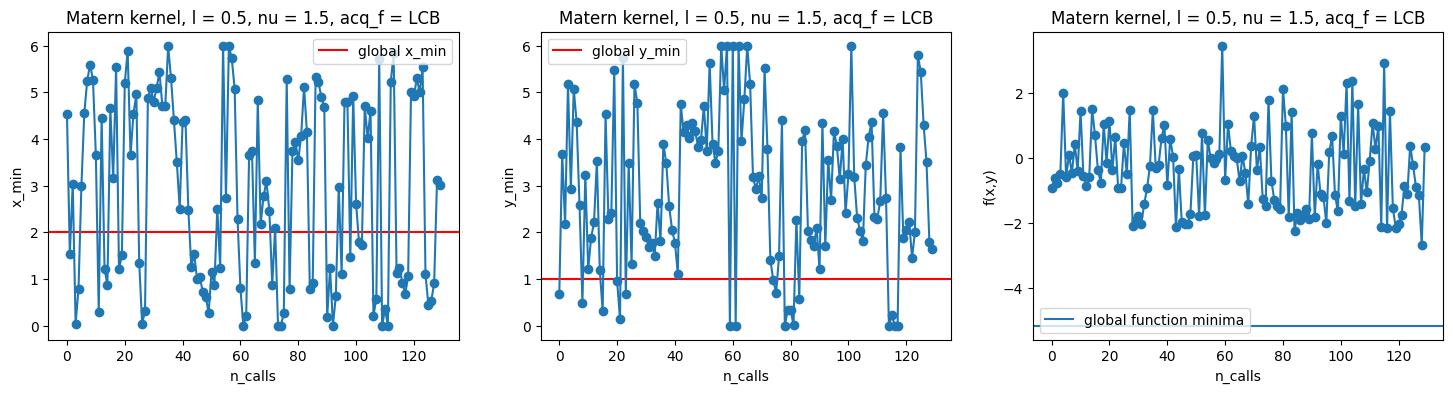

Best parameters: [3.1211890601045957, 1.7888950081516106]
Best score: -2.687524035152726


In [30]:
Ncal=130; l=0.5; v=1.5; ac_f="LCB"; kap = 3.92
modified_matern_langermann_function(Ncal,l,v,ac_f,kap)

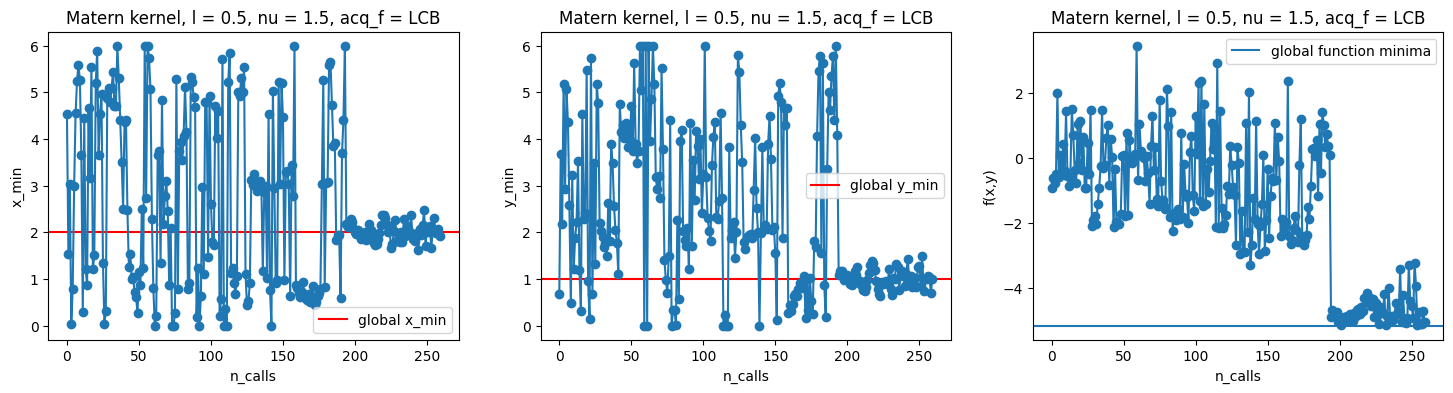

Best parameters: [2.008067851738458, 1.0285259762758439]
Best score: -5.1533073502023825


In [31]:
Ncal=260; l=0.5; v=1.5; ac_f="LCB"; kap = 3.92
modified_matern_langermann_function(Ncal,l,v,ac_f,kap)

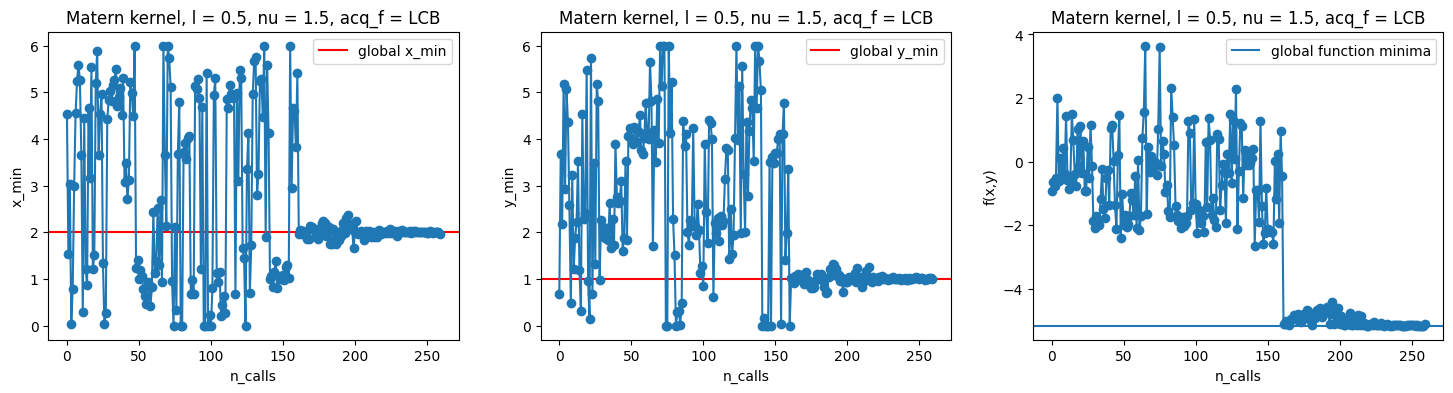

Best parameters: [2.004072436053408, 1.008244171268788]
Best score: -5.162029837419738


In [32]:
Ncal=260; l=0.5; v=1.5; ac_f="LCB"; kap = 3.00
modified_matern_langermann_function(Ncal,l,v,ac_f,kap)

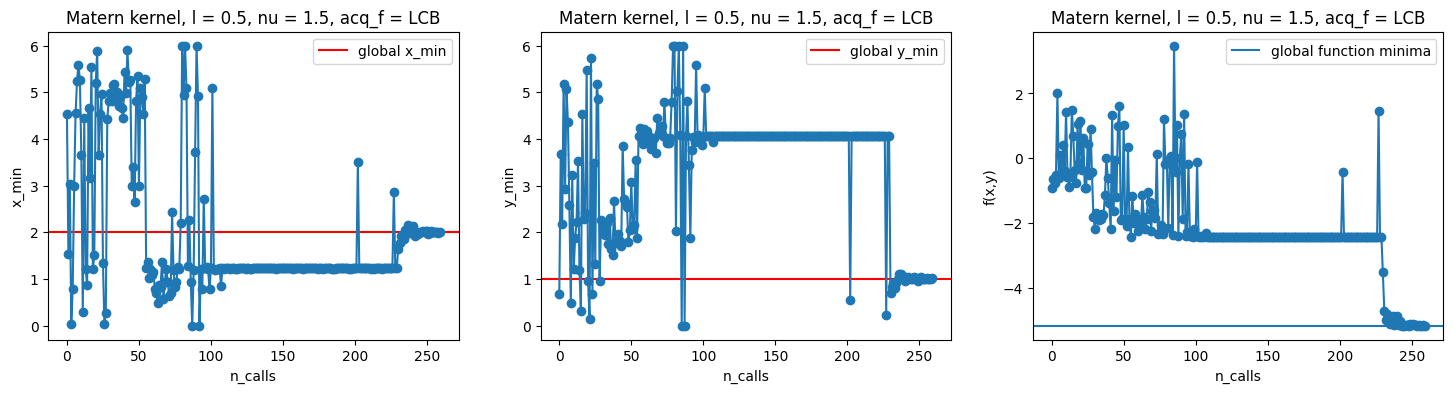

Best parameters: [2.0044033728858714, 1.0034660786599845]
Best score: -5.1619723169784395


In [33]:
Ncal=260; l=0.5; v=1.5; ac_f="LCB"; kap = 2.50
modified_matern_langermann_function(Ncal,l,v,ac_f,kap)

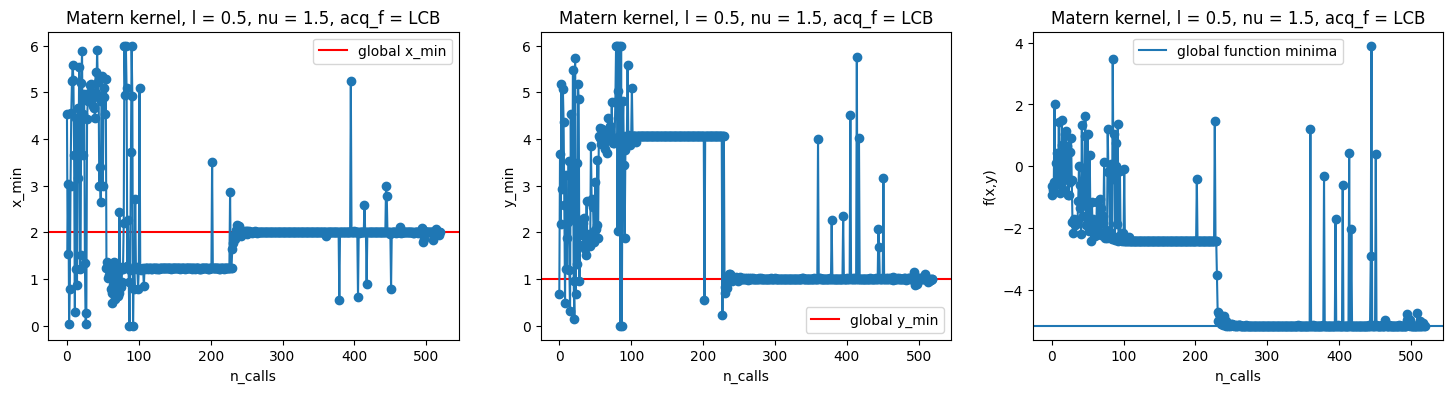

Best parameters: [2.0029921179418024, 1.0060959407142585]
Best score: -5.162126159963981


In [34]:
Ncal=520; l=0.5; v=1.5; ac_f="LCB"; kap = 2.50
modified_matern_langermann_function(Ncal,l,v,ac_f,kap)

## Test out the Matern 5/2 kernel on the (0,6),(0,6) space

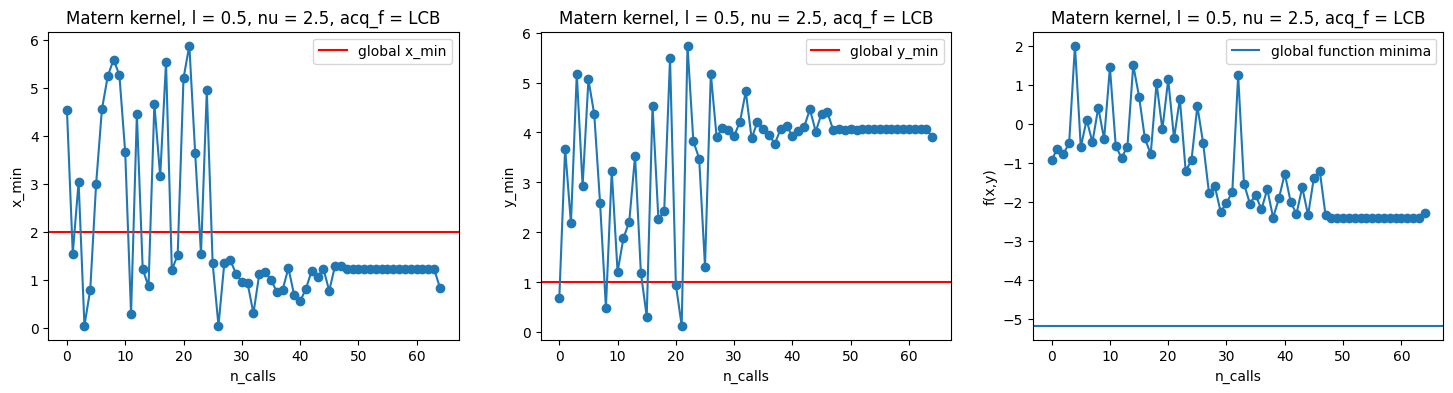

Best parameters: [1.225337007594851, 4.061263971274012]
Best score: -2.4211241564758827


In [36]:
Ncal=65; l=0.5; v=2.5; ac_f="LCB"; kap = 1.96
modified_matern_langermann_function(Ncal,l,v,ac_f,kap)

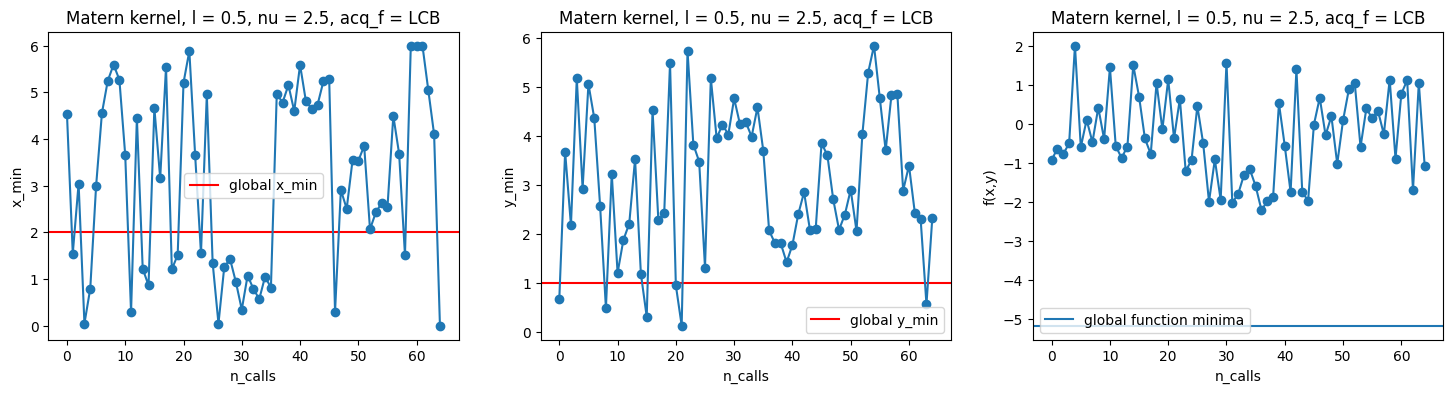

Best parameters: [4.963176411701073, 2.073449398906379]
Best score: -2.2061136218403656


In [37]:
Ncal=65; l=0.5; v=2.5; ac_f="LCB"; kap = 3.92
modified_matern_langermann_function(Ncal,l,v,ac_f,kap)

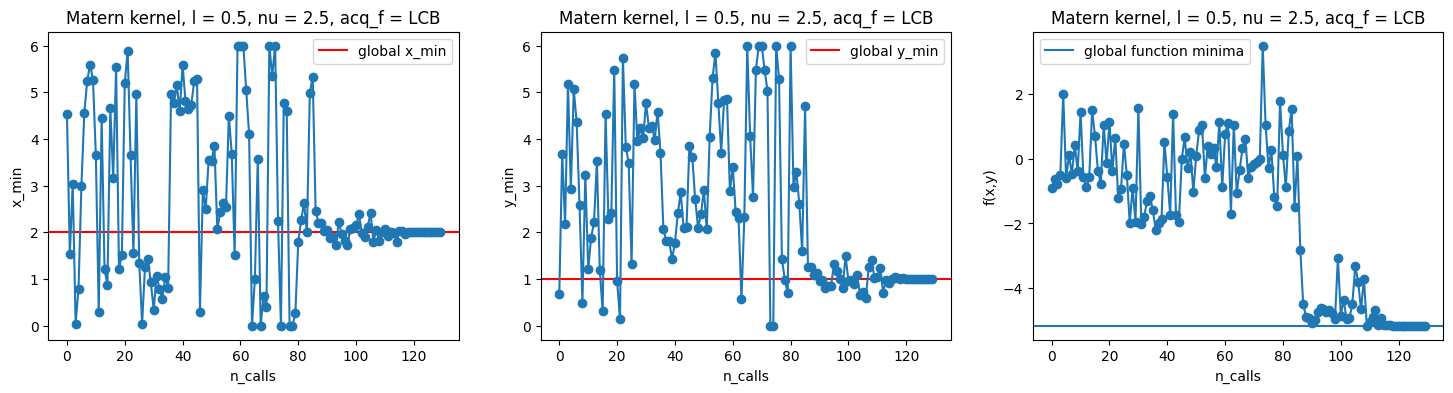

Best parameters: [2.002973649017418, 1.0061093845051607]
Best score: -5.162126150579804


In [38]:
Ncal=130; l=0.5; v=2.5; ac_f="LCB"; kap = 3.92
modified_matern_langermann_function(Ncal,l,v,ac_f,kap)

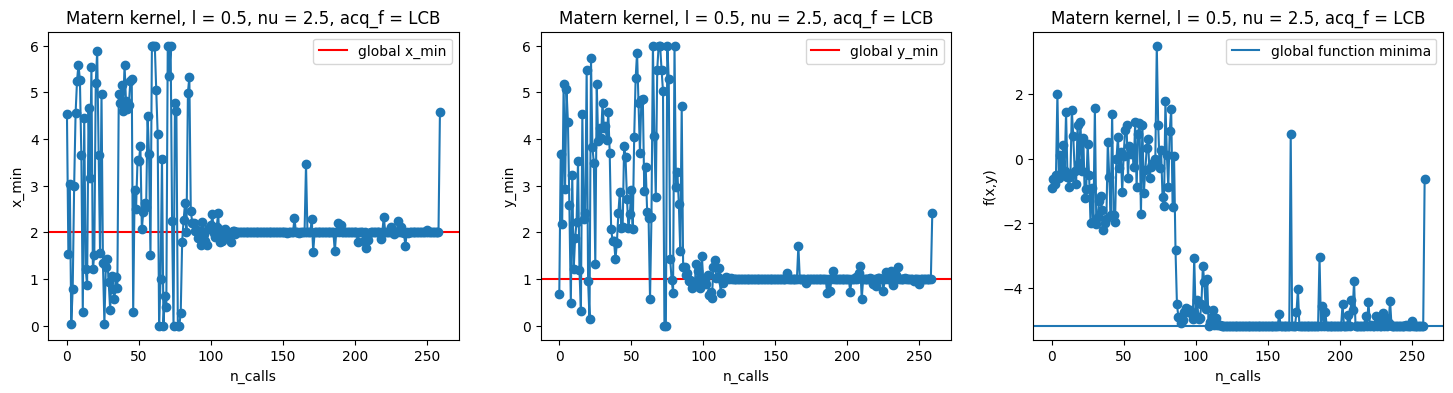

Best parameters: [2.0029921278237732, 1.0060958981353516]
Best score: -5.162126159963952


In [39]:
Ncal=260; l=0.5; v=2.5; ac_f="LCB"; kap = 3.92
modified_matern_langermann_function(Ncal,l,v,ac_f,kap)

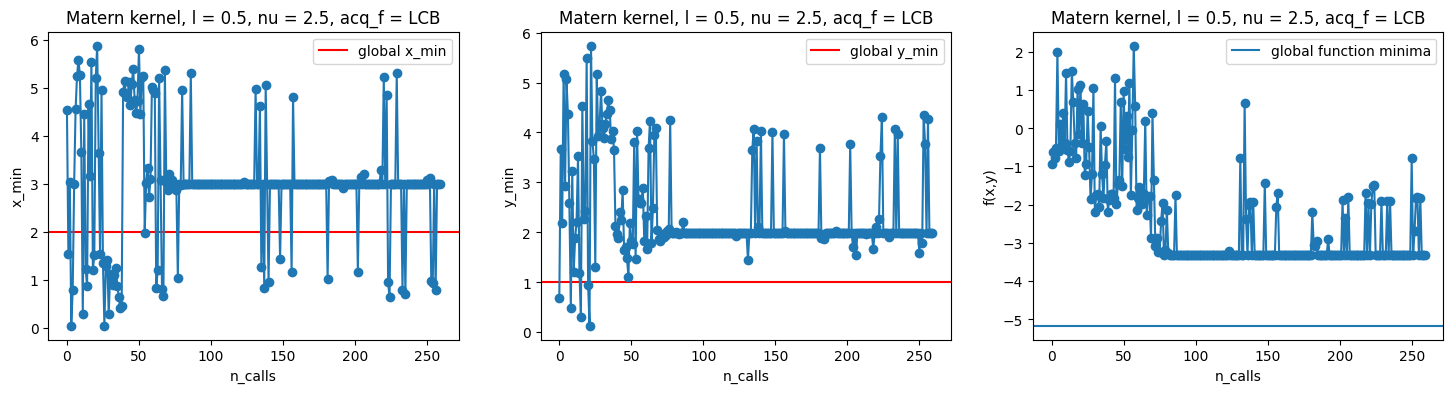

Best parameters: [3.000012120883995, 1.9854158066210337]
Best score: -3.3165448051275246


In [40]:
Ncal=260; l=0.5; v=2.5; ac_f="LCB"; kap = 3.00
modified_matern_langermann_function(Ncal,l,v,ac_f,kap)

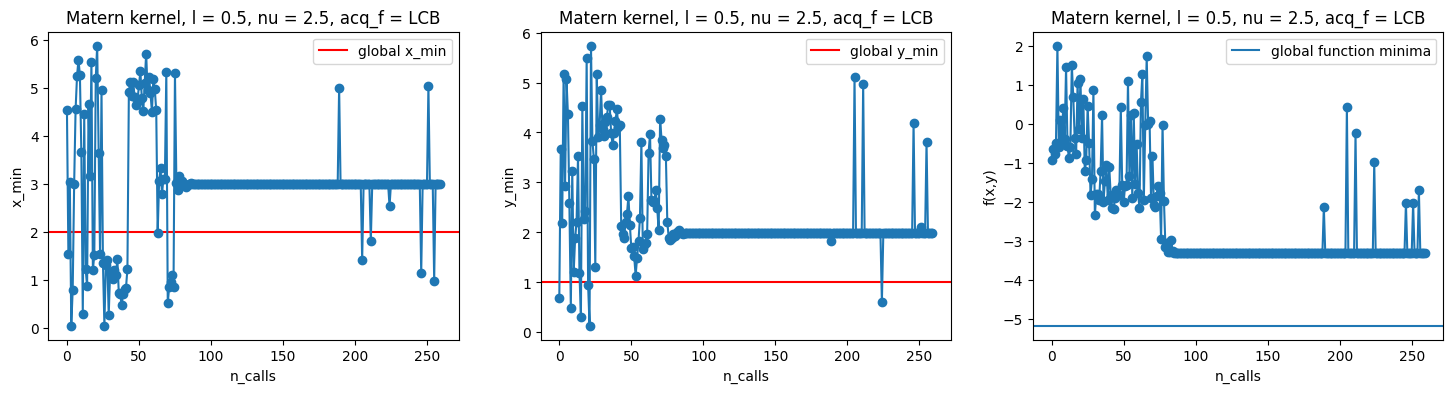

Best parameters: [3.0000119350223864, 1.9854161633084668]
Best score: -3.3165448051212527


In [41]:
Ncal=260; l=0.5; v=2.5; ac_f="LCB"; kap = 2.50
modified_matern_langermann_function(Ncal,l,v,ac_f,kap)

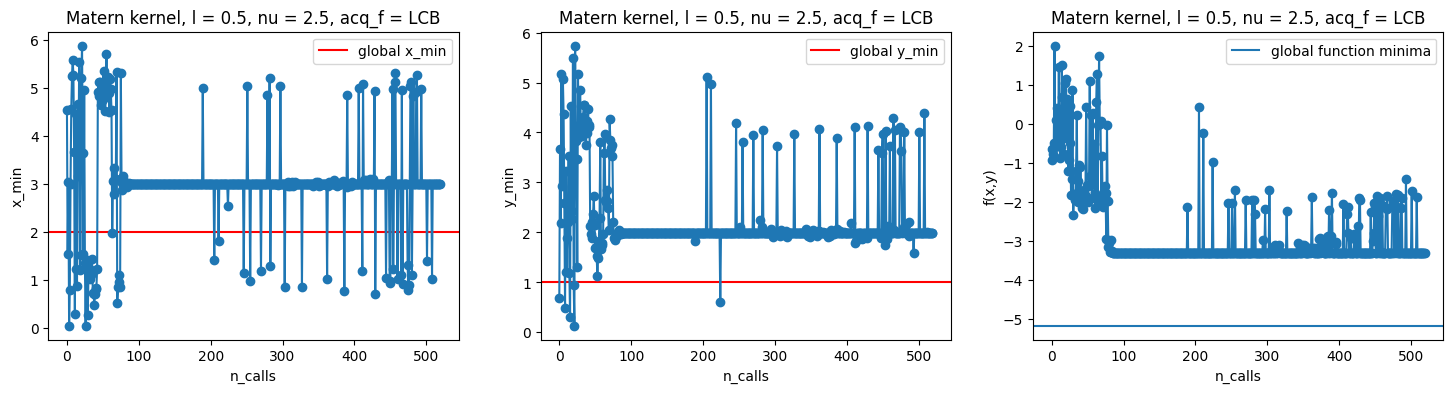

Best parameters: [3.0000120598902185, 1.9854157334139468]
Best score: -3.316544805128616


In [42]:
Ncal=520; l=0.5; v=2.5; ac_f="LCB"; kap = 2.50
modified_matern_langermann_function(Ncal,l,v,ac_f,kap)